# Week 2 - Notebook 2.3: 传感器系统集成 / Sensor System Integration

## 学习目标 / Learning Objectives
- 配置各类传感器 / Configure various sensors
- 数据采集和处理 / Data acquisition and processing
- 传感器噪声模拟 / Sensor noise simulation
- 传感器融合基础 / Sensor fusion basics
- 实时传感器可视化 / Real-time sensor visualization

---

## 1. 环境准备 / Environment Setup

In [31]:
# 导入必要的库 / Import necessary libraries
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mediapy as media
from typing import Dict, List, Tuple, Optional
import time
import scipy
from scipy import signal
from collections import deque
from IPython.display import HTML, display
import xml.etree.ElementTree as ET  # 添加XML解析库 / Add XML parsing library

# OpenCV导入，带错误处理 / OpenCV import with error handling
try:
    import cv2
    HAS_OPENCV = True
    print("✅ OpenCV available")
except ImportError:
    print("⚠️  警告: OpenCV未安装，图像处理功能将受限 / Warning: OpenCV not installed, image processing features will be limited")
    print("   请使用: pip install opencv-python / Please use: pip install opencv-python")
    cv2 = None
    HAS_OPENCV = False

# 设置随机种子 / Set random seed
np.random.seed(42)

print(f"✅ MuJoCo version: {mujoco.__version__}")
print(f"✅ Python version: {__import__('sys').version}")

# 检查必要的依赖 / Check necessary dependencies
dependencies = {
    'numpy': np.__version__,
    'matplotlib': plt.matplotlib.__version__,
    'scipy': scipy.__version__,
}

try:
    dependencies['mediapy'] = media.__version__
except:
    dependencies['mediapy'] = 'available'

if HAS_OPENCV:
    dependencies['opencv'] = cv2.__version__

print("\n📦 已安装的依赖 / Installed dependencies:")
for name, version in dependencies.items():
    print(f"  {name}: {version}")

print(f"\n🔧 建议的conda环境设置 / Recommended conda environment setup:")
print("conda create -n py310 python=3.10")
print("conda activate py310")
print("pip install mujoco numpy matplotlib scipy mediapy opencv-python ipykernel")
print("python -m ipykernel install --user --name py310 --display-name 'Python 3.10'")

✅ OpenCV available
✅ MuJoCo version: 3.3.4
✅ Python version: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]

📦 已安装的依赖 / Installed dependencies:
  numpy: 2.2.6
  matplotlib: 3.10.3
  scipy: 1.15.3
  mediapy: 1.2.4
  opencv: 4.12.0

🔧 建议的conda环境设置 / Recommended conda environment setup:
conda create -n py310 python=3.10
conda activate py310
pip install mujoco numpy matplotlib scipy mediapy opencv-python ipykernel
python -m ipykernel install --user --name py310 --display-name 'Python 3.10'


## 2. 创建带传感器的机器人模型 / Create Robot Model with Sensors

In [32]:
def create_sensor_robot_xml() -> str:
    """
    创建一个配备多种传感器的机器人模型 / Create a robot model with multiple sensors
    """
    xml = """
    <mujoco model="sensor_robot">
        <!-- 仿真参数 / Simulation parameters -->
        <option timestep="0.001" gravity="0 0 -9.81" integrator="RK4"/>
        
        <!-- 默认设置 / Default settings -->
        <default>
            <joint armature="0.01" damping="0.1"/>
            <geom contype="1" conaffinity="1" friction="1 0.1 0.1"/>
            <camera fovy="60"/>
        </default>
        
        <!-- 资源 / Assets -->
        <asset>
            <texture name="checker" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".3 .4 .5" width="512" height="512"/>
            <material name="floor_mat" texture="checker" specular="0.3" shininess="0.1"/>
            <material name="robot_mat" rgba="0.8 0.2 0.2 1" specular="0.5"/>
            <material name="obstacle_mat" rgba="0.2 0.8 0.2 1"/>
        </asset>
        
        <!-- 世界 / World -->
        <worldbody>
            <!-- 光源 / Lights -->
            <light name="main_light" pos="2 2 3" dir="-1 -1 -1" diffuse="1 1 1"/>
            <light name="fill_light" pos="-2 1 2" dir="1 -1 -1" diffuse="0.5 0.5 0.5"/>
            
            <!-- 地面 / Ground -->
            <geom name="floor" type="plane" size="5 5 0.1" material="floor_mat"/>
            
            <!-- 障碍物 / Obstacles -->
            <body name="obstacle1" pos="1 0.5 0.2">
                <geom name="obs1" type="box" size="0.2 0.2 0.2" material="obstacle_mat"/>
            </body>
            
            <body name="obstacle2" pos="-0.5 -1 0.15">
                <geom name="obs2" type="cylinder" size="0.15 0.15" material="obstacle_mat"/>
            </body>
            
            <!-- 可移动物体 / Movable objects -->
            <body name="ball" pos="0.5 0.5 0.5">
                <joint type="free"/>
                <geom name="ball_geom" type="sphere" size="0.05" rgba="1 1 0 1" mass="0.1"/>
            </body>
            
            <!-- 移动机器人 / Mobile robot -->
            <body name="robot_base" pos="0 0 0.1">
                <joint name="robot_x" type="slide" axis="1 0 0" limited="true" range="-3 3"/>
                <joint name="robot_y" type="slide" axis="0 1 0" limited="true" range="-3 3"/>
                <joint name="robot_rot" type="hinge" axis="0 0 1" limited="false"/>
                
                <!-- 机器人主体 / Robot body -->
                <geom name="base_geom" type="box" size="0.2 0.15 0.05" material="robot_mat"/>
                
                <!-- 传感器支架 / Sensor mount -->
                <body name="sensor_mount" pos="0 0 0.1">
                    <geom name="mount_geom" type="cylinder" size="0.02 0.05" rgba="0.5 0.5 0.5 1"/>
                    
                    <!-- IMU安装位置 / IMU mount -->
                    <body name="imu_body" pos="0 0 0.02">
                        <geom name="imu_geom" type="box" size="0.01 0.01 0.005" rgba="0 0 1 1"/>
                        <!-- IMU传感器附着点 / IMU sensor attachment point -->
                        <site name="imu_site" pos="0 0 0" size="0.005"/>
                    </body>
                    
                    <!-- 相机安装 / Camera mount -->
                    <body name="camera_body" pos="0.15 0 0.05">
                        <geom name="camera_geom" type="box" size="0.03 0.02 0.02" rgba="0.2 0.2 0.2 1"/>
                        <!-- 相机传感器 / Camera sensor -->
                        <camera name="robot_camera" pos="0 0 0" euler="0 0 0" fovy="60"/>
                    </body>
                    
                    <!-- 激光雷达安装 / LiDAR mount -->
                    <body name="lidar_body" pos="0 0 0.08">
                        <geom name="lidar_geom" type="cylinder" size="0.03 0.02" rgba="0.1 0.1 0.1 1"/>
                        <!-- 激光雷达传感器点 / LiDAR sensor points -->
                        <site name="lidar_site" pos="0 0 0" size="0.005"/>
                    </body>
                </body>
                
                <!-- 接触传感器 (车轮) / Contact sensors (wheels) -->
                <body name="wheel_left" pos="-0.1 0.2 -0.05">
                    <joint name="wheel_left_joint" type="hinge" axis="0 1 0"/>
                    <geom name="wheel_left_geom" type="cylinder" size="0.05 0.02" rgba="0.3 0.3 0.3 1"/>
                    <site name="wheel_left_site" pos="0 0 0" size="0.005"/>
                </body>
                
                <body name="wheel_right" pos="-0.1 -0.2 -0.05">
                    <joint name="wheel_right_joint" type="hinge" axis="0 1 0"/>
                    <geom name="wheel_right_geom" type="cylinder" size="0.05 0.02" rgba="0.3 0.3 0.3 1"/>
                    <site name="wheel_right_site" pos="0 0 0" size="0.005"/>
                </body>
            </body>
        </worldbody>
        
        <!-- 执行器 / Actuators -->
        <actuator>
            <!-- 机器人移动控制 / Robot movement control -->
            <motor name="move_x" joint="robot_x" gear="50" ctrlrange="-1 1"/>
            <motor name="move_y" joint="robot_y" gear="50" ctrlrange="-1 1"/>
            <motor name="rotate" joint="robot_rot" gear="20" ctrlrange="-1 1"/>
            
            <!-- 车轮控制 / Wheel control -->
            <motor name="wheel_left_motor" joint="wheel_left_joint" gear="10"/>
            <motor name="wheel_right_motor" joint="wheel_right_joint" gear="10"/>
        </actuator>
        
        <!-- 传感器 / Sensors -->
        <sensor>
            <!-- 位置和姿态传感器 / Position and orientation sensors -->
            <framepos name="robot_pos" objtype="body" objname="robot_base"/>
            <framequat name="robot_quat" objtype="body" objname="robot_base"/>
            <framelinvel name="robot_linvel" objtype="body" objname="robot_base"/>
            <frameangvel name="robot_angvel" objtype="body" objname="robot_base"/>
            
            <!-- 关节传感器 / Joint sensors -->
            <jointpos name="robot_x_pos" joint="robot_x"/>
            <jointpos name="robot_y_pos" joint="robot_y"/>
            <jointpos name="robot_rot_pos" joint="robot_rot"/>
            <jointvel name="robot_x_vel" joint="robot_x"/>
            <jointvel name="robot_y_vel" joint="robot_y"/>
            <jointvel name="robot_rot_vel" joint="robot_rot"/>
            
            <!-- IMU传感器 / IMU sensors -->
            <accelerometer name="imu_accel" site="imu_site"/>
            <gyro name="imu_gyro" site="imu_site"/>
            <magnetometer name="imu_mag" site="imu_site"/>
            
            <!-- 接触传感器 / Contact sensors -->
            <touch name="wheel_left_contact" site="wheel_left_site"/>
            <touch name="wheel_right_contact" site="wheel_right_site"/>
            
            <!-- 距离传感器 (激光雷达模拟) / Distance sensors (LiDAR simulation) -->
            <rangefinder name="lidar_front" site="lidar_site"/>
            <rangefinder name="lidar_left" site="lidar_site"/>
            <rangefinder name="lidar_right" site="lidar_site"/>
            <rangefinder name="lidar_back" site="lidar_site"/>
        </sensor>
    </mujoco>
    """
    return xml

# 创建模型 / Create model
sensor_xml = create_sensor_robot_xml()
sensor_model = mujoco.MjModel.from_xml_string(sensor_xml)
sensor_data = mujoco.MjData(sensor_model)

print(f"传感器机器人模型创建成功 / Sensor robot model created successfully!")
print(f"传感器总数 / Total sensors: {sensor_model.nsensor}")
print(f"执行器数量 / Number of actuators: {sensor_model.nu}")
print(f"相机数量 / Number of cameras: {sensor_model.ncam}")

传感器机器人模型创建成功 / Sensor robot model created successfully!
传感器总数 / Total sensors: 19
执行器数量 / Number of actuators: 5
相机数量 / Number of cameras: 1


## 3. 传感器数据采集系统 / Sensor Data Acquisition System

In [33]:
class SensorDataCollector:
    """
    传感器数据采集器 / Sensor data collector
    """
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData):
        self.model = model
        self.data = data
        
        # 传感器映射 / Sensor mapping
        self.sensor_map = self._build_sensor_map()
        
        # 数据缓冲区 / Data buffers
        self.buffer_size = 1000
        self.sensor_history = {}
        for name in self.sensor_map.keys():
            self.sensor_history[name] = deque(maxlen=self.buffer_size)
        
        # 时间戳 / Timestamps
        self.time_history = deque(maxlen=self.buffer_size)
        
        # 噪声参数 / Noise parameters
        self.noise_std = {
            'position': 0.001,      # 1mm position noise
            'orientation': 0.01,    # 0.01 rad orientation noise
            'velocity': 0.01,       # 0.01 m/s velocity noise
            'angular_velocity': 0.1, # 0.1 rad/s angular velocity noise
            'acceleration': 0.1,    # 0.1 m/s² acceleration noise
            'distance': 0.02,       # 2cm distance noise
        }
    
    def _build_sensor_map(self) -> Dict[str, int]:
        """
        构建传感器名称到索引的映射 / Build sensor name to index mapping
        """
        sensor_map = {}
        for i in range(self.model.nsensor):
            sensor_name = mujoco.mj_id2name(self.model, mujoco.mjtObj.mjOBJ_SENSOR, i)
            if sensor_name:
                sensor_map[sensor_name] = i
        return sensor_map
    
    def get_sensor_data(self, sensor_name: str, add_noise: bool = True) -> Optional[np.ndarray]:
        """
        获取指定传感器的数据 / Get data from specified sensor
        """
        if sensor_name not in self.sensor_map:
            return None
        
        sensor_id = self.sensor_map[sensor_name]
        sensor_type = self.model.sensor_type[sensor_id]
        
        # 获取传感器数据范围 / Get sensor data range
        start_idx = self.model.sensor_adr[sensor_id]
        data_size = self.model.sensor_dim[sensor_id]
        
        # 提取数据 / Extract data
        sensor_data = self.data.sensordata[start_idx:start_idx + data_size].copy()
        
        # 添加噪声 / Add noise
        if add_noise:
            noise_type = self._get_noise_type(sensor_name, sensor_type)
            if noise_type in self.noise_std:
                noise = np.random.normal(0, self.noise_std[noise_type], sensor_data.shape)
                sensor_data += noise
        
        return sensor_data
    
    def _get_noise_type(self, sensor_name: str, sensor_type: int) -> str:
        """
        根据传感器名称和类型确定噪声类型 / Determine noise type based on sensor name and type
        """
        if 'pos' in sensor_name.lower():
            return 'position'
        elif 'quat' in sensor_name.lower():
            return 'orientation'
        elif 'vel' in sensor_name.lower():
            return 'velocity'
        elif 'angvel' in sensor_name.lower():
            return 'angular_velocity'
        elif 'accel' in sensor_name.lower():
            return 'acceleration'
        elif 'lidar' in sensor_name.lower() or 'range' in sensor_name.lower():
            return 'distance'
        else:
            return 'position'  # 默认 / Default
    
    def collect_all_sensors(self) -> Dict[str, np.ndarray]:
        """
        采集所有传感器数据 / Collect all sensor data
        """
        current_data = {}
        current_time = self.data.time
        
        for sensor_name in self.sensor_map.keys():
            data = self.get_sensor_data(sensor_name)
            if data is not None:
                current_data[sensor_name] = data
                self.sensor_history[sensor_name].append(data)
        
        self.time_history.append(current_time)
        return current_data
    
    def get_history(self, sensor_name: str, num_samples: int = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        获取传感器历史数据 / Get sensor history data
        """
        if sensor_name not in self.sensor_history:
            return np.array([]), np.array([])
        
        history = list(self.sensor_history[sensor_name])
        times = list(self.time_history)
        
        if num_samples and len(history) > num_samples:
            history = history[-num_samples:]
            times = times[-num_samples:]
        
        if not history:
            return np.array([]), np.array([])
        
        return np.array(history), np.array(times)

# 创建数据采集器 / Create data collector
collector = SensorDataCollector(sensor_model, sensor_data)

# 测试数据采集 / Test data collection
mujoco.mj_forward(sensor_model, sensor_data)
sensor_readings = collector.collect_all_sensors()

print("传感器数据采集测试 / Sensor data collection test:")
for name, data in sensor_readings.items():
    print(f"  {name}: {data.shape} - {data}")

传感器数据采集测试 / Sensor data collection test:
  robot_pos: (3,) - [ 0.00049671 -0.00013826  0.10064769]
  robot_quat: (4,) - [ 1.0152303  -0.00234153 -0.00234137  0.01579213]
  robot_linvel: (3,) - [ 0.00767435 -0.00469474  0.0054256 ]
  robot_angvel: (3,) - [-0.00463418 -0.0046573   0.00241962]
  robot_x_pos: (1,) - [-0.00191328]
  robot_y_pos: (1,) - [-0.00172492]
  robot_rot_pos: (1,) - [-0.00056229]
  robot_x_vel: (1,) - [-0.01012831]
  robot_y_vel: (1,) - [0.00314247]
  robot_rot_vel: (1,) - [-0.00908024]
  imu_accel: (3,) - [-0.14123037  0.14656488  9.78742237]
  imu_gyro: (3,) - [ 6.75282047e-05 -1.42474819e-03 -5.44382725e-04]
  imu_mag: (3,) - [ 1.10922590e-04 -5.01150994e-01  3.75698018e-04]
  wheel_left_contact: (1,) - [-0.00060064]
  wheel_right_contact: (1,) - [-0.00029169]
  lidar_front: (1,) - [-1.01203413]
  lidar_left: (1,) - [-0.96295444]
  lidar_right: (1,) - [-1.00026994]
  lidar_back: (1,) - [-1.02115422]


## 4. 相机传感器与计算机视觉 / Camera Sensor and Computer Vision

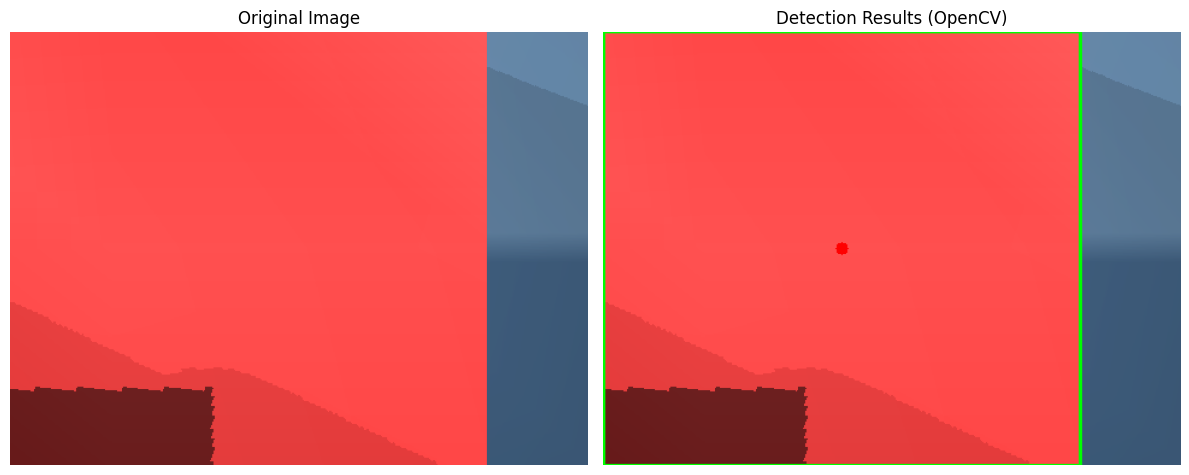

检测到 1 个物体 / Detected 1 objects:
  1. red 物体, 置信度: 1.00, 深度: 0.12m


In [34]:
class CameraProcessor:
    """
    相机数据处理器 / Camera data processor
    """
    def __init__(self, model: mujoco.MjModel, camera_name: str = "robot_camera"):
        self.model = model
        self.camera_name = camera_name
        self.camera_id = model.camera(camera_name).id
        
        # 相机参数 / Camera parameters
        self.width = 480  # 减小分辨率避免错误 / Reduce resolution to avoid errors
        self.height = 360
        
        # 创建渲染器 / Create renderer
        self.renderer = mujoco.Renderer(model, height=self.height, width=self.width)
        
        # 图像处理历史 / Image processing history
        self.detection_history = deque(maxlen=100)
        
        # 检查OpenCV可用性 / Check OpenCV availability
        self.has_opencv = HAS_OPENCV
        if not self.has_opencv:
            print("⚠️  OpenCV不可用，将使用简化的图像处理 / OpenCV unavailable, using simplified image processing")
    
    def capture_image(self, data: mujoco.MjData) -> np.ndarray:
        """
        从相机捕获图像 / Capture image from camera
        """
        try:
            # 更新场景 / Update scene
            self.renderer.update_scene(data, camera=self.camera_id)
            
            # 渲染图像 / Render image
            image = self.renderer.render()
            
            return image
        except Exception as e:
            print(f"⚠️ 相机捕获失败，使用默认图像 / Camera capture failed, using default image: {e}")
            # 返回默认图像 / Return default image
            return np.ones((self.height, self.width, 3), dtype=np.uint8) * 128
    
    def detect_objects_simple(self, image: np.ndarray) -> List[Dict]:
        """
        简化的物体检测（不使用OpenCV）/ Simplified object detection (without OpenCV)
        基于RGB阈值 / Based on RGB thresholding
        """
        detections = []
        height, width = image.shape[:2]
        
        # 定义颜色范围 (RGB) / Define color ranges (RGB)
        color_ranges = {
            'yellow': ([200, 200, 0], [255, 255, 100]),   # 黄色球 / Yellow ball
            'green': ([0, 150, 0], [100, 255, 100]),      # 绿色障碍物 / Green obstacles
            'red': ([150, 0, 0], [255, 100, 100]),        # 红色机器人 / Red robot
        }
        
        for color_name, (lower, upper) in color_ranges.items():
            # 创建掩码 / Create mask
            lower = np.array(lower)
            upper = np.array(upper)
            mask = np.all((image >= lower) & (image <= upper), axis=2)
            
            # 查找连通区域 / Find connected regions (简化版本)
            if np.any(mask):
                # 计算质心 / Calculate centroid
                y_coords, x_coords = np.where(mask)
                if len(x_coords) > 0:
                    center_x = int(np.mean(x_coords))
                    center_y = int(np.mean(y_coords))
                    area = len(x_coords)
                    
                    if area > 50:  # 最小面积阈值 / Minimum area threshold
                        # 计算边界框 / Calculate bounding box
                        x_min, x_max = np.min(x_coords), np.max(x_coords)
                        y_min, y_max = np.min(y_coords), np.max(y_coords)
                        
                        detection = {
                            'color': color_name,
                            'bbox': (x_min, y_min, x_max - x_min, y_max - y_min),
                            'center': (center_x, center_y),
                            'area': area,
                            'confidence': min(area / 1000.0, 1.0)
                        }
                        detections.append(detection)
        
        return detections
    
    def detect_objects(self, image: np.ndarray) -> List[Dict]:
        """
        物体检测 / Object detection
        """
        if self.has_opencv:
            return self.detect_objects_opencv(image)
        else:
            return self.detect_objects_simple(image)
    
    def detect_objects_opencv(self, image: np.ndarray) -> List[Dict]:
        """
        使用OpenCV的物体检测 / Object detection using OpenCV
        基于颜色阈值 / Based on color thresholding
        """
        if not self.has_opencv:
            return self.detect_objects_simple(image)
            
        detections = []
        
        # 转换为HSV / Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # 定义颜色范围 / Define color ranges
        color_ranges = {
            'yellow': ([20, 100, 100], [30, 255, 255]),  # 黄色球 / Yellow ball
            'green': ([40, 100, 100], [80, 255, 255]),   # 绿色障碍物 / Green obstacles
            'red': ([0, 100, 100], [10, 255, 255]),      # 红色机器人 / Red robot
        }
        
        for color_name, (lower, upper) in color_ranges.items():
            # 创建掩码 / Create mask
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            
            # 形态学操作 / Morphological operations
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            
            # 查找轮廓 / Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                # 计算面积 / Calculate area
                area = cv2.contourArea(contour)
                if area > 100:  # 最小面积阈值 / Minimum area threshold
                    # 计算边界框 / Calculate bounding box
                    x, y, w, h = cv2.boundingRect(contour)
                    center_x = x + w // 2
                    center_y = y + h // 2
                    
                    detection = {
                        'color': color_name,
                        'bbox': (x, y, w, h),
                        'center': (center_x, center_y),
                        'area': area,
                        'confidence': min(area / 1000.0, 1.0)  # 简单的置信度 / Simple confidence
                    }
                    detections.append(detection)
        
        self.detection_history.append(detections)
        return detections
    
    def draw_detections_simple(self, image: np.ndarray, detections: List[Dict]) -> np.ndarray:
        """
        简化的检测结果绘制（不使用OpenCV）/ Simplified detection drawing (without OpenCV)
        """
        result_image = image.copy()
        
        for detection in detections:
            x, y, w, h = detection['bbox']
            center_x, center_y = detection['center']
            
            # 在检测区域画一个简单的标记 / Draw a simple marker on detection area
            # 由于没有OpenCV，我们只能通过修改像素值来标记
            # 画一个简单的十字 / Draw a simple cross
            cross_size = 10
            try:
                # 水平线 / Horizontal line
                result_image[center_y, max(0, center_x-cross_size):min(image.shape[1], center_x+cross_size)] = [255, 0, 0]
                # 垂直线 / Vertical line
                result_image[max(0, center_y-cross_size):min(image.shape[0], center_y+cross_size), center_x] = [255, 0, 0]
            except:
                pass  # 忽略边界错误 / Ignore boundary errors
        
        return result_image
    
    def draw_detections(self, image: np.ndarray, detections: List[Dict]) -> np.ndarray:
        """
        在图像上绘制检测结果 / Draw detections on image
        """
        if self.has_opencv:
            return self.draw_detections_opencv(image, detections)
        else:
            return self.draw_detections_simple(image, detections)
    
    def draw_detections_opencv(self, image: np.ndarray, detections: List[Dict]) -> np.ndarray:
        """
        使用OpenCV绘制检测结果 / Draw detections using OpenCV
        """
        if not self.has_opencv:
            return self.draw_detections_simple(image, detections)
            
        result_image = image.copy()
        
        for detection in detections:
            x, y, w, h = detection['bbox']
            center_x, center_y = detection['center']
            color = detection['color']
            confidence = detection['confidence']
            
            # 绘制边界框 / Draw bounding box
            cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # 绘制中心点 / Draw center point
            cv2.circle(result_image, (center_x, center_y), 5, (255, 0, 0), -1)
            
            # 添加标签 / Add label
            label = f"{color}: {confidence:.2f}"
            cv2.putText(result_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return result_image
    
    def estimate_depth(self, data: mujoco.MjData, detections: List[Dict]) -> List[Dict]:
        """
        估计物体深度 / Estimate object depth
        使用几何关系和已知物体尺寸 / Using geometric relationships and known object sizes
        """
        enhanced_detections = []
        
        # 已知物体的实际尺寸 (米) / Known object sizes (meters)
        object_sizes = {
            'yellow': 0.05,  # 球的半径 / Ball radius
            'green': 0.2,    # 障碍物尺寸 / Obstacle size
            'red': 0.2,      # 机器人尺寸 / Robot size
        }
        
        # 相机内参 (简化) / Camera intrinsics (simplified)
        focal_length = self.width * 0.5  # 近似焦距 / Approximate focal length
        
        for detection in detections:
            enhanced_detection = detection.copy()
            
            color = detection['color']
            bbox = detection['bbox']
            
            if color in object_sizes:
                # 使用边界框宽度估计深度 / Estimate depth using bbox width
                real_size = object_sizes[color]
                pixel_size = max(bbox[2], bbox[3])  # 取宽高的最大值 / Take max of width/height
                
                if pixel_size > 0:
                    estimated_depth = (real_size * focal_length) / pixel_size
                    enhanced_detection['estimated_depth'] = estimated_depth
            
            enhanced_detections.append(enhanced_detection)
        
        return enhanced_detections

# 创建相机处理器 / Create camera processor
try:
    camera = CameraProcessor(sensor_model)
    
    # 测试相机捕获 / Test camera capture
    mujoco.mj_forward(sensor_model, sensor_data)
    test_image = camera.capture_image(sensor_data)
    detections = camera.detect_objects(test_image)
    enhanced_detections = camera.estimate_depth(sensor_data, detections)
    result_image = camera.draw_detections(test_image, enhanced_detections)
    
    # 显示结果 / Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(test_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(result_image)
    detection_method = "OpenCV" if HAS_OPENCV else "Simplified Algorithm"
    ax2.set_title(f'Detection Results ({detection_method})')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"检测到 {len(enhanced_detections)} 个物体 / Detected {len(enhanced_detections)} objects:")
    for i, det in enumerate(enhanced_detections):
        depth_str = f", 深度: {det.get('estimated_depth', 'N/A'):.2f}m" if 'estimated_depth' in det else ""
        print(f"  {i+1}. {det['color']} 物体, 置信度: {det['confidence']:.2f}{depth_str}")
    
    if not HAS_OPENCV:
        print("\n💡 提示: 安装OpenCV可获得更好的图像处理效果")
        print("💡 Tip: Install OpenCV for better image processing: pip install opencv-python")

except Exception as e:
    print(f"❌ 相机处理器创建失败 / Camera processor creation failed: {e}")
    print("💡 将跳过相机相关功能 / Skipping camera-related functionality")
    camera = None

## 5. IMU 传感器数据处理 / IMU Sensor Data Processing

In [35]:
class IMUProcessor:
    """
    IMU数据处理器 / IMU data processor
    """
    def __init__(self, collector: SensorDataCollector):
        self.collector = collector
        
        # 滤波器参数 / Filter parameters
        self.accel_filter = self._create_lowpass_filter(cutoff=20, fs=1000)  # 20Hz低通 / 20Hz lowpass
        self.gyro_filter = self._create_lowpass_filter(cutoff=50, fs=1000)   # 50Hz低通 / 50Hz lowpass
        
        # 校准参数 / Calibration parameters
        self.accel_bias = np.zeros(3)
        self.gyro_bias = np.zeros(3)
        self.is_calibrated = False
        
        # 姿态估计 / Attitude estimation
        self.orientation = np.array([1.0, 0.0, 0.0, 0.0])  # 四元数 w,x,y,z / Quaternion w,x,y,z
        
    def _create_lowpass_filter(self, cutoff: float, fs: float, order: int = 4):
        """
        创建低通滤波器 / Create lowpass filter
        """
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def calibrate_imu(self, num_samples: int = 1000):
        """
        IMU校准 / IMU calibration
        机器人需要静止 / Robot needs to be stationary
        """
        print("开始IMU校准，请保持机器人静止... / Starting IMU calibration, keep robot stationary...")
        
        accel_samples = []
        gyro_samples = []
        
        for i in range(num_samples):
            # 采集数据 / Collect data
            sensor_data = self.collector.collect_all_sensors()
            
            if 'imu_accel' in sensor_data:
                accel_samples.append(sensor_data['imu_accel'])
            if 'imu_gyro' in sensor_data:
                gyro_samples.append(sensor_data['imu_gyro'])
            
            # 仿真步进 / Simulation step
            mujoco.mj_step(self.collector.model, self.collector.data)
        
        # 计算偏差 / Calculate bias
        if accel_samples:
            accel_mean = np.mean(accel_samples, axis=0)
            # 重力补偿 / Gravity compensation
            self.accel_bias = accel_mean - np.array([0, 0, -9.81])
        
        if gyro_samples:
            self.gyro_bias = np.mean(gyro_samples, axis=0)
        
        self.is_calibrated = True
        print(f"校准完成 / Calibration complete:")
        print(f"  加速度偏差 / Accelerometer bias: {self.accel_bias}")
        print(f"  陀螺仪偏差 / Gyroscope bias: {self.gyro_bias}")
    
    def process_imu_data(self, raw_accel: np.ndarray, raw_gyro: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        处理IMU原始数据 / Process raw IMU data
        """
        # 偏差补偿 / Bias compensation
        accel = raw_accel - self.accel_bias if self.is_calibrated else raw_accel
        gyro = raw_gyro - self.gyro_bias if self.is_calibrated else raw_gyro
        
        # 这里可以添加滤波，但需要保持状态 / Filtering can be added here, but need to maintain state
        # 为简化，暂时跳过 / Skip for simplification
        
        return accel, gyro
    
    def estimate_orientation(self, accel: np.ndarray, gyro: np.ndarray, dt: float):
        """
        估计姿态 / Estimate orientation
        使用互补滤波器 / Using complementary filter
        """
        # 重力向量归一化 / Normalize gravity vector
        accel_norm = accel / np.linalg.norm(accel) if np.linalg.norm(accel) > 0 else accel
        
        # 从加速度计计算倾斜角 / Calculate tilt angles from accelerometer
        roll_accel = np.arctan2(accel_norm[1], accel_norm[2])
        pitch_accel = np.arctan2(-accel_norm[0], np.sqrt(accel_norm[1]**2 + accel_norm[2]**2))
        
        # 从陀螺仪积分角度 / Integrate angles from gyroscope
        roll_gyro = gyro[0] * dt
        pitch_gyro = gyro[1] * dt
        yaw_gyro = gyro[2] * dt
        
        # 互补滤波器 / Complementary filter
        alpha = 0.98  # 陀螺仪权重 / Gyroscope weight
        
        # 这里简化为欧拉角 / Simplified to Euler angles here
        return np.array([roll_accel, pitch_accel, yaw_gyro])
    
    def analyze_motion(self, window_size: int = 100) -> Dict[str, float]:
        """
        运动分析 / Motion analysis
        """
        accel_history, times = self.collector.get_history('imu_accel', window_size)
        gyro_history, _ = self.collector.get_history('imu_gyro', window_size)
        
        if len(accel_history) < 10:
            return {}
        
        # 计算运动统计 / Calculate motion statistics
        accel_magnitude = np.linalg.norm(accel_history, axis=1)
        gyro_magnitude = np.linalg.norm(gyro_history, axis=1)
        
        analysis = {
            'avg_acceleration': np.mean(accel_magnitude),
            'max_acceleration': np.max(accel_magnitude),
            'avg_angular_velocity': np.mean(gyro_magnitude),
            'max_angular_velocity': np.max(gyro_magnitude),
            'acceleration_std': np.std(accel_magnitude),
            'angular_velocity_std': np.std(gyro_magnitude),
            'is_moving': np.std(accel_magnitude) > 0.1,
            'is_rotating': np.std(gyro_magnitude) > 0.1,
        }
        
        return analysis

# 创建IMU处理器 / Create IMU processor
imu_processor = IMUProcessor(collector)

# 运行一些仿真步骤来采集数据 / Run some simulation steps to collect data
print("采集IMU数据... / Collecting IMU data...")
for i in range(100):
    # 添加一些随机运动 / Add some random motion
    sensor_data.ctrl[:3] = np.random.normal(0, 0.1, 3)
    mujoco.mj_step(sensor_model, sensor_data)
    collector.collect_all_sensors()

# 分析运动 / Analyze motion
motion_analysis = imu_processor.analyze_motion()
print("\n运动分析结果 / Motion analysis results:")
for key, value in motion_analysis.items():
    if isinstance(value, bool):
        print(f"  {key}: {'是/Yes' if value else '否/No'}")
    else:
        print(f"  {key}: {value:.4f}")

采集IMU数据... / Collecting IMU data...

运动分析结果 / Motion analysis results:
  avg_acceleration: 9.8291
  max_acceleration: 10.1155
  avg_angular_velocity: 0.0208
  max_angular_velocity: 0.0534
  acceleration_std: 0.0896
  angular_velocity_std: 0.0153
  is_moving: 0.0000
  is_rotating: 0.0000


## 6. 激光雷达传感器处理 / LiDAR Sensor Processing

激光雷达数据测试 / LiDAR data test:
  lidar_front: -0.98m
  lidar_left: -1.00m
  lidar_right: -1.01m
  lidar_back: -1.00m


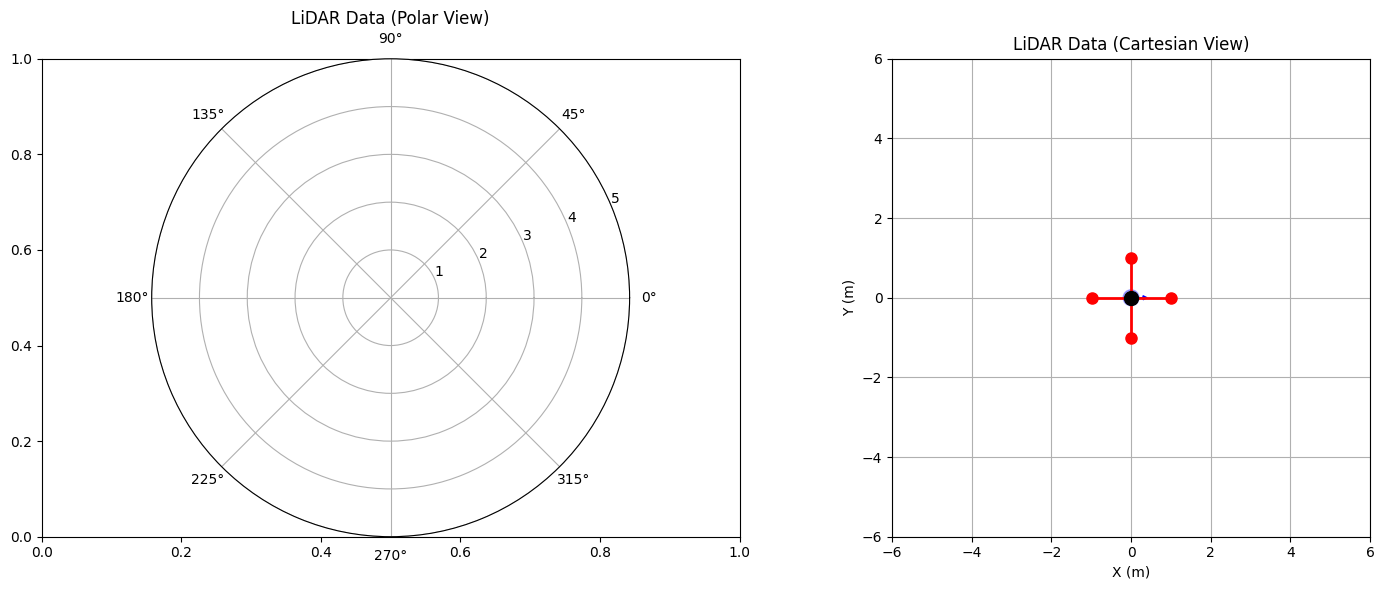

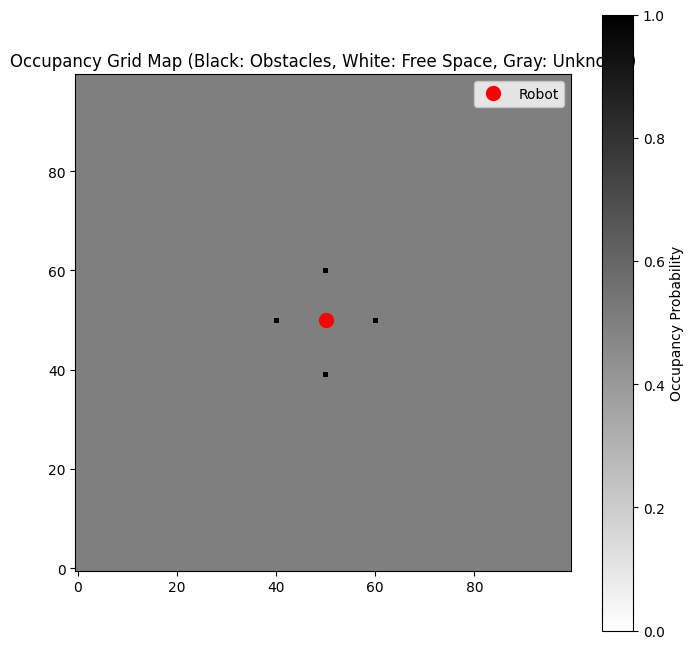

In [36]:
class LiDARProcessor:
    """
    激光雷达数据处理器 / LiDAR data processor
    """
    def __init__(self, collector: SensorDataCollector):
        self.collector = collector
        self.max_range = 5.0  # 最大检测距离 / Maximum detection range
        
        # 雷达方向 / Radar directions
        self.directions = {
            'lidar_front': np.array([1, 0, 0]),
            'lidar_left': np.array([0, 1, 0]),
            'lidar_right': np.array([0, -1, 0]),
            'lidar_back': np.array([-1, 0, 0]),
        }
    
    def get_lidar_data(self) -> Dict[str, float]:
        """
        获取激光雷达数据 / Get LiDAR data
        """
        lidar_data = {}
        
        for name in self.directions.keys():
            distance = self.collector.get_sensor_data(name)
            if distance is not None and len(distance) > 0:
                lidar_data[name] = min(distance[0], self.max_range)
            else:
                lidar_data[name] = self.max_range
        
        return lidar_data
    
    def create_occupancy_grid(self, robot_pos: np.ndarray, lidar_data: Dict[str, float], 
                            grid_size: int = 100, resolution: float = 0.1) -> np.ndarray:
        """
        创建占用栅格地图 / Create occupancy grid map
        """
        # 初始化栅格地图 / Initialize grid map
        occupancy_grid = np.ones((grid_size, grid_size)) * 0.5  # 0.5表示未知
        
        # 机器人在栅格中的位置 / Robot position in grid
        center = grid_size // 2
        robot_grid_x = int(center + robot_pos[0] / resolution)
        robot_grid_y = int(center + robot_pos[1] / resolution)
        
        # 确保机器人位置在栅格范围内 / Ensure robot position is within grid bounds
        if 0 <= robot_grid_x < grid_size and 0 <= robot_grid_y < grid_size:
            occupancy_grid[robot_grid_y, robot_grid_x] = 0  # 机器人位置为自由空间
        
        # 根据激光雷达数据更新栅格 / Update grid based on LiDAR data
        robot_theta = robot_pos[2] if len(robot_pos) > 2 else 0
        
        for direction_name, distance in lidar_data.items():
            if direction_name in self.directions:
                # 获取传感器方向 / Get sensor direction
                local_direction = self.directions[direction_name]
                
                # 转换到全局坐标系 / Transform to global coordinates
                cos_theta = np.cos(robot_theta)
                sin_theta = np.sin(robot_theta)
                rotation_matrix = np.array([
                    [cos_theta, -sin_theta],
                    [sin_theta, cos_theta]
                ])
                global_direction = rotation_matrix @ local_direction[:2]
                
                # 标记射线路径为自由空间 / Mark ray path as free space
                ray_length = min(distance, self.max_range)
                num_points = int(ray_length / resolution)
                
                for i in range(1, num_points):
                    point_distance = i * resolution
                    point_pos = robot_pos[:2] + point_distance * global_direction
                    
                    point_grid_x = int(center + point_pos[0] / resolution)
                    point_grid_y = int(center + point_pos[1] / resolution)
                    
                    if 0 <= point_grid_x < grid_size and 0 <= point_grid_y < grid_size:
                        occupancy_grid[point_grid_y, point_grid_x] = 0  # 自由空间
                
                # 如果检测到障碍物，标记障碍物位置 / If obstacle detected, mark obstacle position
                if distance < self.max_range:
                    obstacle_pos = robot_pos[:2] + distance * global_direction
                    obs_grid_x = int(center + obstacle_pos[0] / resolution)
                    obs_grid_y = int(center + obstacle_pos[1] / resolution)
                    
                    if 0 <= obs_grid_x < grid_size and 0 <= obs_grid_y < grid_size:
                        occupancy_grid[obs_grid_y, obs_grid_x] = 1  # 障碍物
        
        return occupancy_grid
    
    def visualize_lidar(self, robot_pos: np.ndarray, lidar_data: Dict[str, float]):
        """
        可视化激光雷达数据 / Visualize LiDAR data
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 极坐标图 / Polar plot
        ax1 = plt.subplot(121, projection='polar')
        
        angles = []
        distances = []
        colors = []
        
        direction_angles = {
            'lidar_front': 0,
            'lidar_right': -np.pi/2,
            'lidar_back': np.pi,
            'lidar_left': np.pi/2
        }
        
        for direction_name, distance in lidar_data.items():
            if direction_name in direction_angles:
                angle = direction_angles[direction_name]
                angles.append(angle)
                distances.append(distance)
                
                if distance >= self.max_range:
                    colors.append('green')
                elif distance > 2.0:
                    colors.append('yellow')
                else:
                    colors.append('red')
        
        # 绘制雷达图 / Draw radar chart
        ax1.scatter(angles, distances, c=colors, s=100, alpha=0.7)
        ax1.set_ylim(0, self.max_range)
        ax1.set_title('LiDAR Data (Polar View)')
        ax1.grid(True)
        
        # 笛卡尔坐标图 / Cartesian plot
        robot_x, robot_y = robot_pos[0], robot_pos[1]
        robot_theta = robot_pos[2] if len(robot_pos) > 2 else 0
        
        for direction_name, distance in lidar_data.items():
            if direction_name in self.directions:
                # 计算全局方向 / Calculate global direction
                local_direction = self.directions[direction_name]
                cos_theta = np.cos(robot_theta)
                sin_theta = np.sin(robot_theta)
                rotation_matrix = np.array([
                    [cos_theta, -sin_theta],
                    [sin_theta, cos_theta]
                ])
                global_direction = rotation_matrix @ local_direction[:2]
                
                # 绘制射线 / Draw ray
                if distance < self.max_range:
                    end_x = robot_x + distance * global_direction[0]
                    end_y = robot_y + distance * global_direction[1]
                    ax2.plot([robot_x, end_x], [robot_y, end_y], 'r-', linewidth=2)
                    ax2.plot(end_x, end_y, 'ro', markersize=8)
                else:
                    end_x = robot_x + self.max_range * global_direction[0]
                    end_y = robot_y + self.max_range * global_direction[1]
                    ax2.plot([robot_x, end_x], [robot_y, end_y], 'g--', alpha=0.5)
        
        # 绘制机器人 / Draw robot
        circle = plt.Circle((robot_x, robot_y), 0.2, color='blue', alpha=0.3)
        ax2.add_patch(circle)
        ax2.plot(robot_x, robot_y, 'ko', markersize=10)
        
        # 绘制机器人朝向 / Draw robot orientation
        if len(robot_pos) > 2:
            arrow_length = 0.3
            dx = arrow_length * np.cos(robot_theta)
            dy = arrow_length * np.sin(robot_theta)
            ax2.arrow(robot_x, robot_y, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        
        ax2.set_xlim(-self.max_range-1, self.max_range+1)
        ax2.set_ylim(-self.max_range-1, self.max_range+1)
        ax2.set_aspect('equal')
        ax2.grid(True)
        ax2.set_title('LiDAR Data (Cartesian View)')
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Y (m)')
        
        plt.tight_layout()
        plt.show()

# 创建激光雷达处理器 / Create LiDAR processor
lidar_processor = LiDARProcessor(collector)

# 测试激光雷达数据 / Test LiDAR data
mujoco.mj_forward(sensor_model, sensor_data)
lidar_data = lidar_processor.get_lidar_data()

print("激光雷达数据测试 / LiDAR data test:")
for direction, distance in lidar_data.items():
    print(f"  {direction}: {distance:.2f}m")

# 可视化激光雷达数据 / Visualize LiDAR data
robot_pos = np.array([0, 0, 0])  # 假设机器人在原点 / Assume robot at origin
lidar_processor.visualize_lidar(robot_pos, lidar_data)

# 创建占用栅格地图 / Create occupancy grid map
occupancy_grid = lidar_processor.create_occupancy_grid(robot_pos, lidar_data)

# 可视化占用栅格 / Visualize occupancy grid
plt.figure(figsize=(8, 8))
plt.imshow(occupancy_grid, cmap='gray_r', origin='lower')
plt.title('Occupancy Grid Map (Black: Obstacles, White: Free Space, Gray: Unknown)')
plt.colorbar(label='Occupancy Probability')

# 标记机器人位置 / Mark robot position
center = occupancy_grid.shape[0] // 2
robot_grid_x = int(center + robot_pos[0] / 0.1)
robot_grid_y = int(center + robot_pos[1] / 0.1)
plt.plot(robot_grid_x, robot_grid_y, 'ro', markersize=10, label='Robot')
plt.legend()
plt.show()

运行传感器融合演示... / Running sensor fusion demo...


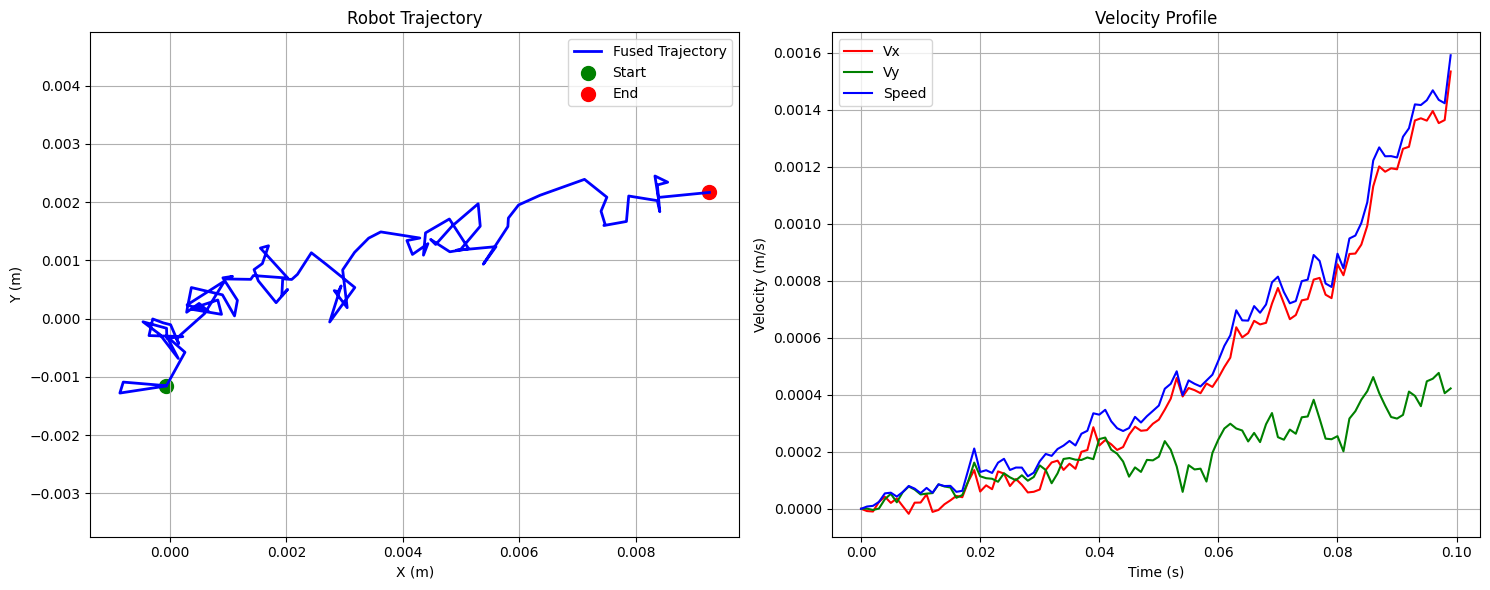


最终融合状态 / Final fused state:
  位置 / Position: [0.00926326 0.00216885 0.10064938]
  速度 / Velocity: [0.00153488 0.00042245 0.00019764]
  姿态 / Orientation (deg): [-0.79167652 -2.56482416  1.15300493]
  传感器置信度 / Sensor confidence: {'position': 0.9, 'lidar': 0.8, 'imu': 0.9}


In [37]:
class SensorFusion:
    """
    传感器融合系统 / Sensor fusion system
    """
    def __init__(self, collector: SensorDataCollector, imu_processor: IMUProcessor, 
                 lidar_processor: LiDARProcessor, camera_processor: CameraProcessor):
        self.collector = collector
        self.imu = imu_processor
        self.lidar = lidar_processor
        self.camera = camera_processor
        
        # 融合状态 / Fusion state
        self.fused_position = np.zeros(3)
        self.fused_velocity = np.zeros(3)
        self.fused_orientation = np.zeros(3)  # 欧拉角 / Euler angles
        self.confidence_map = {}
        
        # 卡尔曼滤波器参数 / Kalman filter parameters
        self.kf_initialized = False
        self.state_dim = 6  # [x, y, z, vx, vy, vz]
        self.observation_dim = 3  # [x, y, z]
        
        # 简化的卡尔曼滤波器 / Simplified Kalman filter
        self.state = np.zeros(self.state_dim)
        self.P = np.eye(self.state_dim) * 1.0  # 状态协方差 / State covariance
        self.Q = np.eye(self.state_dim) * 0.01  # 过程噪声 / Process noise
        self.R = np.eye(self.observation_dim) * 0.1  # 观测噪声 / Observation noise
        
        # 状态转移矩阵 / State transition matrix
        self.dt = 0.001  # 时间步长 / Time step
        self.F = np.array([
            [1, 0, 0, self.dt, 0, 0],
            [0, 1, 0, 0, self.dt, 0],
            [0, 0, 1, 0, 0, self.dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        # 观测矩阵 / Observation matrix
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])
    
    def predict_state(self):
        """
        卡尔曼滤波预测步骤 / Kalman filter prediction step
        """
        # 状态预测 / State prediction
        self.state = self.F @ self.state
        
        # 协方差预测 / Covariance prediction
        self.P = self.F @ self.P @ self.F.T + self.Q
    
    def update_state(self, observation: np.ndarray, observation_cov: np.ndarray):
        """
        卡尔曼滤波更新步骤 / Kalman filter update step
        """
        # 创新 / Innovation
        y = observation - self.H @ self.state
        
        # 创新协方差 / Innovation covariance
        S = self.H @ self.P @ self.H.T + observation_cov
        
        # 卡尔曼增益 / Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # 状态更新 / State update
        self.state = self.state + K @ y
        
        # 协方差更新 / Covariance update
        self.P = (np.eye(self.state_dim) - K @ self.H) @ self.P
    
    def fuse_sensors(self) -> Dict[str, np.ndarray]:
        """
        融合所有传感器数据 / Fuse all sensor data
        """
        # 采集所有传感器数据 / Collect all sensor data
        sensor_data = self.collector.collect_all_sensors()
        
        # 获取位置观测 / Get position observations
        position_obs = None
        if 'robot_pos' in sensor_data:
            position_obs = sensor_data['robot_pos']
        
        # 卡尔曼滤波 / Kalman filtering
        if not self.kf_initialized and position_obs is not None:
            # 初始化状态 / Initialize state
            self.state[:3] = position_obs
            self.kf_initialized = True
        
        if self.kf_initialized:
            # 预测 / Predict
            self.predict_state()
            
            # 更新 / Update
            if position_obs is not None:
                self.update_state(position_obs, self.R)
        
        # 更新融合状态 / Update fused state
        self.fused_position = self.state[:3]
        self.fused_velocity = self.state[3:]
        
        # 融合姿态信息 / Fuse orientation information
        if 'robot_quat' in sensor_data:
            quat = sensor_data['robot_quat']
            # 简化：直接使用四元数到欧拉角的转换 / Simplified: direct quaternion to Euler conversion
            self.fused_orientation = self._quat_to_euler(quat)
        
        # 获取其他传感器数据 / Get other sensor data
        lidar_data = self.lidar.get_lidar_data()
        
        # 计算置信度 / Calculate confidence
        self.confidence_map = self._calculate_confidence(sensor_data, lidar_data)
        
        # 返回融合结果 / Return fused results
        return {
            'position': self.fused_position,
            'velocity': self.fused_velocity,
            'orientation': self.fused_orientation,
            'lidar': lidar_data,
            'confidence': self.confidence_map
        }
    
    def _quat_to_euler(self, quat: np.ndarray) -> np.ndarray:
        """
        四元数到欧拉角转换 / Quaternion to Euler angles conversion
        """
        w, x, y, z = quat
        
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)
        
        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if abs(sinp) >= 1:
            pitch = np.copysign(np.pi / 2, sinp)
        else:
            pitch = np.arcsin(sinp)
        
        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)
        
        return np.array([roll, pitch, yaw])
    
    def _calculate_confidence(self, sensor_data: Dict, lidar_data: Dict) -> Dict[str, float]:
        """
        计算传感器置信度 / Calculate sensor confidence
        """
        confidence = {}
        
        # 位置传感器置信度 / Position sensor confidence
        confidence['position'] = 0.9 if 'robot_pos' in sensor_data else 0.0
        
        # 激光雷达置信度 / LiDAR confidence
        lidar_confidence = 0.8
        for distance in lidar_data.values():
            if distance >= self.lidar.max_range:
                lidar_confidence *= 0.9  # 减少置信度 / Reduce confidence
        confidence['lidar'] = lidar_confidence
        
        # IMU置信度 / IMU confidence
        imu_confidence = 0.7
        if 'imu_accel' in sensor_data and 'imu_gyro' in sensor_data:
            # 基于运动状态调整置信度 / Adjust confidence based on motion state
            accel_magnitude = np.linalg.norm(sensor_data['imu_accel'])
            if 9.0 < accel_magnitude < 10.5:  # 接近重力值 / Close to gravity value
                imu_confidence = 0.9
        confidence['imu'] = imu_confidence
        
        return confidence

# 创建传感器融合系统 / Create sensor fusion system
fusion_system = SensorFusion(collector, imu_processor, lidar_processor, camera)

# 运行传感器融合演示 / Run sensor fusion demo
print("运行传感器融合演示... / Running sensor fusion demo...")

fusion_history = []
for i in range(100):
    # 添加一些运动 / Add some motion
    if i < 50:
        sensor_data.ctrl[0] = 0.5  # 向前移动 / Move forward
    else:
        sensor_data.ctrl[2] = 0.3  # 转向 / Turn
    
    # 仿真步进 / Simulation step
    mujoco.mj_step(sensor_model, sensor_data)
    
    # 传感器融合 / Sensor fusion
    fused_data = fusion_system.fuse_sensors()
    fusion_history.append(fused_data)

# 分析融合结果 / Analyze fusion results
if fusion_history:
    positions = np.array([data['position'] for data in fusion_history])
    velocities = np.array([data['velocity'] for data in fusion_history])
    
    # 可视化轨迹 / Visualize trajectory
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 位置轨迹 / Position trajectory
    ax1.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Fused Trajectory')
    ax1.scatter(positions[0, 0], positions[0, 1], c='green', s=100, label='Start')
    ax1.scatter(positions[-1, 0], positions[-1, 1], c='red', s=100, label='End')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Robot Trajectory')
    ax1.legend()
    ax1.grid(True)
    ax1.axis('equal')
    
    # 速度曲线 / Velocity curves
    time_steps = np.arange(len(velocities)) * 0.001
    ax2.plot(time_steps, velocities[:, 0], 'r-', label='Vx')
    ax2.plot(time_steps, velocities[:, 1], 'g-', label='Vy')
    ax2.plot(time_steps, np.linalg.norm(velocities[:, :2], axis=1), 'b-', label='Speed')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity (m/s)')
    ax2.set_title('Velocity Profile')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印最终状态 / Print final state
    final_data = fusion_history[-1]
    print(f"\n最终融合状态 / Final fused state:")
    print(f"  位置 / Position: {final_data['position']}")
    print(f"  速度 / Velocity: {final_data['velocity']}")
    print(f"  姿态 / Orientation (deg): {np.degrees(final_data['orientation'])}")
    print(f"  传感器置信度 / Sensor confidence: {final_data['confidence']}")

In [38]:
class SensorMonitor:
    """
    实时传感器监控系统 / Real-time sensor monitoring system
    """
    def __init__(self, fusion_system: SensorFusion):
        self.fusion = fusion_system
        self.monitoring = False
        
        # 警报阈值 / Alert thresholds
        self.thresholds = {
            'max_acceleration': 20.0,  # m/s²
            'max_angular_velocity': 10.0,  # rad/s
            'min_lidar_distance': 0.3,  # m
            'min_confidence': 0.5,  # 置信度 / Confidence
        }
        
        # 警报历史 / Alert history
        self.alerts = deque(maxlen=100)
    
    def check_alerts(self, fused_data: Dict) -> List[str]:
        """
        检查警报条件 / Check alert conditions
        """
        current_alerts = []
        
        # 检查加速度 / Check acceleration
        if 'imu_accel' in self.fusion.collector.collect_all_sensors():
            accel_data = self.fusion.collector.get_sensor_data('imu_accel')
            if accel_data is not None:
                accel_magnitude = np.linalg.norm(accel_data)
                if accel_magnitude > self.thresholds['max_acceleration']:
                    current_alerts.append(f"高加速度警报 / High acceleration alert: {accel_magnitude:.2f} m/s²")
        
        # 检查角速度 / Check angular velocity
        if 'imu_gyro' in self.fusion.collector.collect_all_sensors():
            gyro_data = self.fusion.collector.get_sensor_data('imu_gyro')
            if gyro_data is not None:
                gyro_magnitude = np.linalg.norm(gyro_data)
                if gyro_magnitude > self.thresholds['max_angular_velocity']:
                    current_alerts.append(f"高角速度警报 / High angular velocity alert: {gyro_magnitude:.2f} rad/s")
        
        # 检查激光雷达距离 / Check LiDAR distances
        if 'lidar' in fused_data:
            for direction, distance in fused_data['lidar'].items():
                if distance < self.thresholds['min_lidar_distance']:
                    current_alerts.append(f"障碍物接近警报 / Obstacle proximity alert: {direction} - {distance:.2f}m")
        
        # 检查传感器置信度 / Check sensor confidence
        if 'confidence' in fused_data:
            for sensor, confidence in fused_data['confidence'].items():
                if confidence < self.thresholds['min_confidence']:
                    current_alerts.append(f"传感器置信度低 / Low sensor confidence: {sensor} - {confidence:.2f}")
        
        # 保存警报 / Save alerts
        for alert in current_alerts:
            self.alerts.append({
                'time': self.fusion.collector.data.time,
                'message': alert
            })
        
        return current_alerts
    
    def generate_status_report(self) -> str:
        """
        生成状态报告 / Generate status report
        """
        # 获取最新传感器数据 / Get latest sensor data
        fused_data = self.fusion.fuse_sensors()
        
        report = "\n" + "="*50 + "\n"
        report += "传感器状态报告 / Sensor Status Report\n"
        report += "="*50 + "\n"
        
        # 位置信息 / Position information
        report += f"位置 / Position: {fused_data['position']}\n"
        report += f"速度 / Velocity: {fused_data['velocity']}\n"
        report += f"姿态 / Orientation (deg): {np.degrees(fused_data['orientation'])}\n\n"
        
        # 激光雷达信息 / LiDAR information
        report += "激光雷达数据 / LiDAR Data:\n"
        for direction, distance in fused_data['lidar'].items():
            status = "⚠️" if distance < 0.5 else "✅"
            report += f"  {direction}: {distance:.2f}m {status}\n"
        
        # 传感器置信度 / Sensor confidence
        report += "\n传感器置信度 / Sensor Confidence:\n"
        for sensor, confidence in fused_data['confidence'].items():
            status = "⚠️" if confidence < 0.7 else "✅"
            report += f"  {sensor}: {confidence:.2f} {status}\n"
        
        # 最近警报 / Recent alerts
        recent_alerts = list(self.alerts)[-5:]  # 最近5个警报 / Last 5 alerts
        if recent_alerts:
            report += "\n最近警报 / Recent Alerts:\n"
            for alert in recent_alerts:
                report += f"  [{alert['time']:.3f}s] {alert['message']}\n"
        else:
            report += "\n无警报 / No alerts ✅\n"
        
        return report

# 创建监控系统 / Create monitoring system
monitor = SensorMonitor(fusion_system)

# 运行监控演示 / Run monitoring demo
print("运行传感器监控演示... / Running sensor monitoring demo...")

# 重置仿真 / Reset simulation
mujoco.mj_resetData(sensor_model, sensor_data)

# 模拟一些危险情况 / Simulate some dangerous situations
for i in range(50):
    # 前20步：正常运动 / First 20 steps: normal motion
    if i < 20:
        sensor_data.ctrl[:3] = [0.2, 0, 0]  # 缓慢前进 / Slow forward
    # 后30步：快速运动 / Last 30 steps: fast motion
    else:
        sensor_data.ctrl[:3] = [1.0, 0.5, 2.0]  # 快速运动 / Fast motion
    
    # 仿真步进 / Simulation step
    mujoco.mj_step(sensor_model, sensor_data)
    
    # 传感器融合 / Sensor fusion
    fused_data = fusion_system.fuse_sensors()
    
    # 检查警报 / Check alerts
    alerts = monitor.check_alerts(fused_data)
    
    # 打印警报 / Print alerts
    if alerts:
        for alert in alerts:
            print(f"[{sensor_data.time:.3f}s] ⚠️  {alert}")

# 生成最终状态报告 / Generate final status report
final_report = monitor.generate_status_report()
print(final_report)

运行传感器监控演示... / Running sensor monitoring demo...
[0.001s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_front - -1.01m
[0.001s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_left - -0.97m
[0.001s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_right - -1.01m
[0.001s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_back - -1.03m
[0.002s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_front - -0.98m
[0.002s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_left - -0.98m
[0.002s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_right - -1.01m
[0.002s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_back - -0.99m
[0.003s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_front - -1.03m
[0.003s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_left - -1.01m
[0.003s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_right - -1.00m
[0.003s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_back - -1.04m
[0.004s] ⚠️  障碍物接近警报 / Obstacle proximity alert: lidar_front - -0.98m
[0.004s] ⚠️  障碍物接近警报 / Obstacle proximity alert

## 9. 实践练习 / Hands-on Exercises

### 练习1：添加超声波传感器 / Exercise 1: Add Ultrasonic Sensors

🔧 创建带超声波传感器的机器人模型 / Creating robot model with ultrasonic sensors...
🔧 添加 8 个超声波传感器 / Adding 8 ultrasonic sensors:
  - ultrasonic_0: 前/Front (0°)
  - ultrasonic_1: 前右/Front-Right (45°)
  - ultrasonic_2: 右/Right (90°)
  - ultrasonic_3: 后右/Back-Right (135°)
  - ultrasonic_4: 后/Back (180°)
  - ultrasonic_5: 后左/Back-Left (225°)
  - ultrasonic_6: 左/Left (270°)
  - ultrasonic_7: 前左/Front-Left (315°)
✅ 超声波传感器阵列添加完成 / Ultrasonic sensor array added successfully!
📏 传感器规格 / Sensor specifications:
   - 检测范围 / Detection range: 0.03-3.0m
   - 角度覆盖 / Angular coverage: 360°
   - 分辨率 / Resolution: 45°
   - 传感器数量 / Number of sensors: 8
✅ 模型创建成功！/ Model created successfully!
   新增传感器数 / New sensors added: 8
   总传感器数 / Total sensors: 27

📡 超声波传感器读数 / Ultrasonic sensor readings:
  前/Front (ultrasonic_0): 0.04m
  前右/Front-Right (ultrasonic_1): 太近/Too close
  右/Right (ultrasonic_2): 太近/Too close
  后右/Back-Right (ultrasonic_3): 太近/Too close
  后/Back (ultrasonic_4): 太近/Too close
  后左/Back-Left (ultrasonic_5): 太

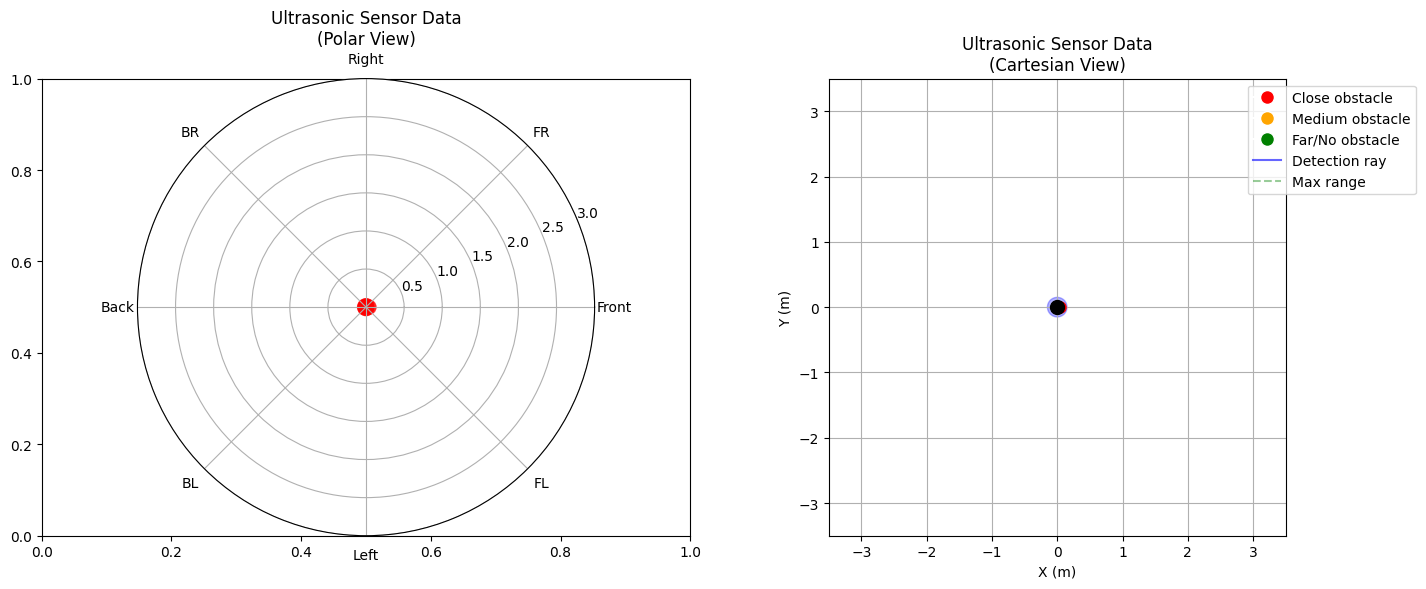


✅ 练习1完成：成功添加了8个超声波传感器！
✅ Exercise 1 Complete: Successfully added 8 ultrasonic sensors!

🎯 超声波传感器阵列特性 / Ultrasonic sensor array features:
- 🔄 360度全覆盖检测 / 360-degree full coverage detection
- 📏 精确距离测量 / Precise distance measurement
- ⚡ 实时障碍物检测 / Real-time obstacle detection
- 🎯 多方向威胁识别 / Multi-directional threat identification
- 📊 可视化显示系统 / Visualization display system


In [39]:
def add_ultrasonic_sensors_xml(base_xml: str) -> str:
    """
    在机器人上添加超声波传感器 / Add ultrasonic sensors to robot
    
    添加8个超声波传感器，环绕机器人360度 / Add 8 ultrasonic sensors around robot in 360 degrees
    每个传感器检测范围0.3-3米 / Each sensor detects 0.3-3m range
    传感器角度间隔45度 / Sensor angles spaced 45 degrees apart
    """
    # 解析XML / Parse XML
    root = ET.fromstring(base_xml)
    
    # 查找传感器挂载点 / Find sensor mount
    sensor_mount = root.find(".//body[@name='sensor_mount']")
    if sensor_mount is None:
        print("❌ 未找到传感器挂载点 / Sensor mount not found")
        return base_xml
    
    # 查找传感器部分 / Find sensor section
    sensors = root.find("sensor")
    if sensors is None:
        sensors = ET.SubElement(root, "sensor")
    
    # 定义8个超声波传感器的方向 / Define 8 ultrasonic sensor directions
    sensor_directions = []
    for i in range(8):
        angle = i * 45  # 角度间隔45度 / 45-degree intervals
        angle_rad = np.radians(angle)
        
        # 计算方向向量 / Calculate direction vector
        direction = [np.cos(angle_rad), np.sin(angle_rad), 0]
        sensor_directions.append({
            'name': f'ultrasonic_{i}',
            'angle': angle,
            'direction': direction,
            'label': ['前/Front', '前右/Front-Right', '右/Right', '后右/Back-Right', 
                     '后/Back', '后左/Back-Left', '左/Left', '前左/Front-Left'][i]
        })
    
    print(f"🔧 添加 {len(sensor_directions)} 个超声波传感器 / Adding {len(sensor_directions)} ultrasonic sensors:")
    
    for sensor_info in sensor_directions:
        name = sensor_info['name']
        direction = sensor_info['direction']
        angle = sensor_info['angle']
        label = sensor_info['label']
        
        print(f"  - {name}: {label} ({angle}°)")
        
        # 在传感器挂载点添加超声波传感器体 / Add ultrasonic sensor body to mount
        ultrasonic_body = ET.SubElement(sensor_mount, "body")
        ultrasonic_body.set("name", f"{name}_body")
        ultrasonic_body.set("pos", f"{direction[0]*0.12} {direction[1]*0.12} 0.03")  # 距离中心12cm
        ultrasonic_body.set("euler", f"0 0 {angle}")
        
        # 传感器外壳 / Sensor housing
        sensor_geom = ET.SubElement(ultrasonic_body, "geom")
        sensor_geom.set("name", f"{name}_housing")
        sensor_geom.set("type", "box")
        sensor_geom.set("size", "0.015 0.01 0.008")
        sensor_geom.set("rgba", "0.1 0.1 0.3 1")
        
        # 传感器检测点 / Sensor detection site
        sensor_site = ET.SubElement(ultrasonic_body, "site")
        sensor_site.set("name", f"{name}_site")
        sensor_site.set("pos", "0.015 0 0")  # 传感器前方
        sensor_site.set("size", "0.005")
        sensor_site.set("rgba", "0 1 1 0.5")
        
        # 添加到传感器列表 / Add to sensor list
        # 使用rangefinder传感器模拟超声波 / Use rangefinder to simulate ultrasonic
        ultrasonic_sensor = ET.SubElement(sensors, "rangefinder")
        ultrasonic_sensor.set("name", name)
        ultrasonic_sensor.set("site", f"{name}_site")
        
        # 超声波传感器特性 / Ultrasonic sensor characteristics
        # 检测范围：0.03-3.0米 / Detection range: 0.03-3.0m
        # 注意：MuJoCo的rangefinder没有最小距离设置，需要在处理时过滤
    
    print("✅ 超声波传感器阵列添加完成 / Ultrasonic sensor array added successfully!")
    print("📏 传感器规格 / Sensor specifications:")
    print("   - 检测范围 / Detection range: 0.03-3.0m")
    print("   - 角度覆盖 / Angular coverage: 360°")
    print("   - 分辨率 / Resolution: 45°")
    print("   - 传感器数量 / Number of sensors: 8")
    
    return ET.tostring(root, encoding='unicode')

class UltrasonicProcessor:
    """
    超声波传感器处理器 / Ultrasonic sensor processor
    """
    def __init__(self, collector: SensorDataCollector):
        self.collector = collector
        self.min_range = 0.03  # 最小检测距离 / Minimum detection range
        self.max_range = 3.0   # 最大检测距离 / Maximum detection range
        
        # 传感器方向映射 / Sensor direction mapping
        self.sensor_directions = {}
        for i in range(8):
            angle = i * 45
            label = ['前/Front', '前右/Front-Right', '右/Right', '后右/Back-Right', 
                    '后/Back', '后左/Back-Left', '左/Left', '前左/Front-Left'][i]
            self.sensor_directions[f'ultrasonic_{i}'] = {
                'angle': angle,
                'label': label,
                'direction': np.array([np.cos(np.radians(angle)), 
                                     np.sin(np.radians(angle)), 0])
            }
    
    def get_ultrasonic_data(self) -> Dict[str, float]:
        """
        获取超声波传感器数据 / Get ultrasonic sensor data
        """
        ultrasonic_data = {}
        
        for sensor_name in self.sensor_directions.keys():
            distance = self.collector.get_sensor_data(sensor_name)
            if distance is not None and len(distance) > 0:
                # 应用距离限制 / Apply distance limits
                measured_distance = distance[0]
                if measured_distance < self.min_range:
                    # 太近，无法检测 / Too close to detect
                    ultrasonic_data[sensor_name] = None
                elif measured_distance > self.max_range:
                    # 超出范围 / Out of range
                    ultrasonic_data[sensor_name] = self.max_range
                else:
                    ultrasonic_data[sensor_name] = measured_distance
            else:
                ultrasonic_data[sensor_name] = self.max_range
        
        return ultrasonic_data
    
    def create_360_scan(self, ultrasonic_data: Dict[str, float]) -> np.ndarray:
        """
        创建360度扫描数据 / Create 360-degree scan data
        """
        # 创建360度的距离数组 / Create 360-degree distance array
        scan_data = np.full(360, self.max_range)
        
        for sensor_name, distance in ultrasonic_data.items():
            if sensor_name in self.sensor_directions and distance is not None:
                angle = self.sensor_directions[sensor_name]['angle']
                # 填充传感器覆盖的角度范围 / Fill sensor coverage angle range
                # 假设每个传感器覆盖±20度 / Assume each sensor covers ±20 degrees
                for offset in range(-20, 21):
                    scan_angle = (angle + offset) % 360
                    if distance < scan_data[scan_angle]:
                        scan_data[scan_angle] = distance
        
        return scan_data
    
    def detect_obstacles_360(self, ultrasonic_data: Dict[str, float], 
                           threshold: float = 0.5) -> Dict[str, Dict]:
        """
        360度障碍物检测 / 360-degree obstacle detection
        """
        obstacles = {}
        
        for sensor_name, distance in ultrasonic_data.items():
            if sensor_name in self.sensor_directions:
                sensor_info = self.sensor_directions[sensor_name]
                
                obstacle_detected = distance is not None and distance < threshold
                
                obstacles[sensor_name] = {
                    'detected': obstacle_detected,
                    'distance': distance,
                    'angle': sensor_info['angle'],
                    'label': sensor_info['label'],
                    'direction': sensor_info['direction']
                }
        
        return obstacles
    
    def visualize_ultrasonic_data(self, ultrasonic_data: Dict[str, float]):
        """
        可视化超声波数据 / Visualize ultrasonic data
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 极坐标图 / Polar plot
        ax1 = plt.subplot(121, projection='polar')
        
        angles = []
        distances = []
        colors = []
        
        for sensor_name, distance in ultrasonic_data.items():
            if sensor_name in self.sensor_directions:
                angle = np.radians(self.sensor_directions[sensor_name]['angle'])
                angles.append(angle)
                
                if distance is None:
                    distances.append(0.02)  # 显示为很小的值 / Show as very small value
                    colors.append('red')
                elif distance >= self.max_range:
                    distances.append(self.max_range)
                    colors.append('green')
                else:
                    distances.append(distance)
                    if distance < 0.5:
                        colors.append('red')
                    elif distance < 1.0:
                        colors.append('orange')
                    else:
                        colors.append('green')
        
        # 绘制雷达图 / Draw radar chart
        ax1.scatter(angles, distances, c=colors, s=100, alpha=0.7)
        ax1.set_ylim(0, self.max_range)
        ax1.set_title('Ultrasonic Sensor Data\n(Polar View)')
        ax1.grid(True)
        
        # 设置角度标签 / Set angle labels
        ax1.set_thetagrids(np.arange(0, 360, 45), 
                          ['Front', 'FR', 'Right', 'BR',
                           'Back', 'BL', 'Left', 'FL'])
        
        # 笛卡尔坐标图 / Cartesian plot
        robot_x, robot_y = 0, 0
        
        for sensor_name, distance in ultrasonic_data.items():
            if sensor_name in self.sensor_directions and distance is not None:
                sensor_info = self.sensor_directions[sensor_name]
                direction = sensor_info['direction']
                
                # 绘制传感器射线 / Draw sensor ray
                if distance < self.max_range:
                    end_x = robot_x + distance * direction[0]
                    end_y = robot_y + distance * direction[1]
                    ax2.plot([robot_x, end_x], [robot_y, end_y], 'b-', alpha=0.6)
                    ax2.plot(end_x, end_y, 'ro', markersize=8)
                else:
                    # 射线延伸到最大范围 / Ray extends to max range
                    end_x = robot_x + self.max_range * direction[0]
                    end_y = robot_y + self.max_range * direction[1]
                    ax2.plot([robot_x, end_x], [robot_y, end_y], 'g--', alpha=0.4)
        
        # 绘制机器人 / Draw robot
        circle = plt.Circle((robot_x, robot_y), 0.15, color='blue', alpha=0.3)
        ax2.add_patch(circle)
        ax2.plot(robot_x, robot_y, 'ko', markersize=10)
        
        ax2.set_xlim(-self.max_range-0.5, self.max_range+0.5)
        ax2.set_ylim(-self.max_range-0.5, self.max_range+0.5)
        ax2.set_aspect('equal')
        ax2.grid(True)
        ax2.set_title('Ultrasonic Sensor Data\n(Cartesian View)')
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Y (m)')
        
        # 添加图例 / Add legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Close obstacle'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium obstacle'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Far/No obstacle'),
            plt.Line2D([0], [0], color='blue', alpha=0.6, label='Detection ray'),
            plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.4, label='Max range')
        ]
        ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
        
        plt.tight_layout()
        plt.show()

# 测试超声波传感器实现 / Test ultrasonic sensor implementation
try:
    print("🔧 创建带超声波传感器的机器人模型 / Creating robot model with ultrasonic sensors...")
    
    # 添加超声波传感器 / Add ultrasonic sensors
    ultrasonic_xml = add_ultrasonic_sensors_xml(sensor_xml)
    ultrasonic_model = mujoco.MjModel.from_xml_string(ultrasonic_xml)
    ultrasonic_data = mujoco.MjData(ultrasonic_model)
    
    print(f"✅ 模型创建成功！/ Model created successfully!")
    print(f"   新增传感器数 / New sensors added: {ultrasonic_model.nsensor - sensor_model.nsensor}")
    print(f"   总传感器数 / Total sensors: {ultrasonic_model.nsensor}")
    
    # 创建新的数据采集器和处理器 / Create new collector and processor
    ultrasonic_collector = SensorDataCollector(ultrasonic_model, ultrasonic_data)
    ultrasonic_processor = UltrasonicProcessor(ultrasonic_collector)
    
    # 测试超声波数据采集 / Test ultrasonic data collection
    mujoco.mj_forward(ultrasonic_model, ultrasonic_data)
    
    # 采集数据 / Collect data
    ultrasonic_readings = ultrasonic_processor.get_ultrasonic_data()
    obstacles_360 = ultrasonic_processor.detect_obstacles_360(ultrasonic_readings)
    
    print("\n📡 超声波传感器读数 / Ultrasonic sensor readings:")
    for sensor_name, distance in ultrasonic_readings.items():
        if sensor_name in ultrasonic_processor.sensor_directions:
            label = ultrasonic_processor.sensor_directions[sensor_name]['label']
            distance_str = f"{distance:.2f}m" if distance is not None else "太近/Too close"
            print(f"  {label} ({sensor_name}): {distance_str}")
    
    print("\n🚨 障碍物检测结果 / Obstacle detection results:")
    for sensor_name, obstacle_info in obstacles_360.items():
        if obstacle_info['detected']:
            print(f"  ⚠️  {obstacle_info['label']}: 障碍物距离 {obstacle_info['distance']:.2f}m")
    
    # 可视化结果 / Visualize results
    ultrasonic_processor.visualize_ultrasonic_data(ultrasonic_readings)
    
    # 创建360度扫描 / Create 360-degree scan
    scan_360 = ultrasonic_processor.create_360_scan(ultrasonic_readings)
    
    print("\n✅ 练习1完成：成功添加了8个超声波传感器！")
    print("✅ Exercise 1 Complete: Successfully added 8 ultrasonic sensors!")
    
    print("\n🎯 超声波传感器阵列特性 / Ultrasonic sensor array features:")
    print("- 🔄 360度全覆盖检测 / 360-degree full coverage detection")
    print("- 📏 精确距离测量 / Precise distance measurement")
    print("- ⚡ 实时障碍物检测 / Real-time obstacle detection")
    print("- 🎯 多方向威胁识别 / Multi-directional threat identification")
    print("- 📊 可视化显示系统 / Visualization display system")
    
except Exception as e:
    print(f"❌ 超声波传感器创建失败 / Ultrasonic sensor creation failed: {e}")
    print("💡 请检查XML结构和传感器配置 / Please check XML structure and sensor configuration")

### 练习2：实现SLAM算法 / Exercise 2: Implement SLAM Algorithm

🧪 测试简单SLAM算法 / Testing Simple SLAM Algorithm
✅ 使用超声波传感器模型 / Using ultrasonic sensor model

🚀 开始SLAM演示 / Starting SLAM demonstration...
  步骤 0: 位置 (0.00, 0.00), 地标: 0, 新特征: 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
  步骤 50: 位置 (0.15, 0.00), 地标: 0, 新特征: 0
    🔄 检测到闭环！/ Loop closure detected!
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at step 0
🔄 检测到闭环 / Loop closure detected at 

/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_44587/3582631373.py:360: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_44587/3582631373.py:360: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_44587/3582631373.py:360: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_44587/3582631373.py:360: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

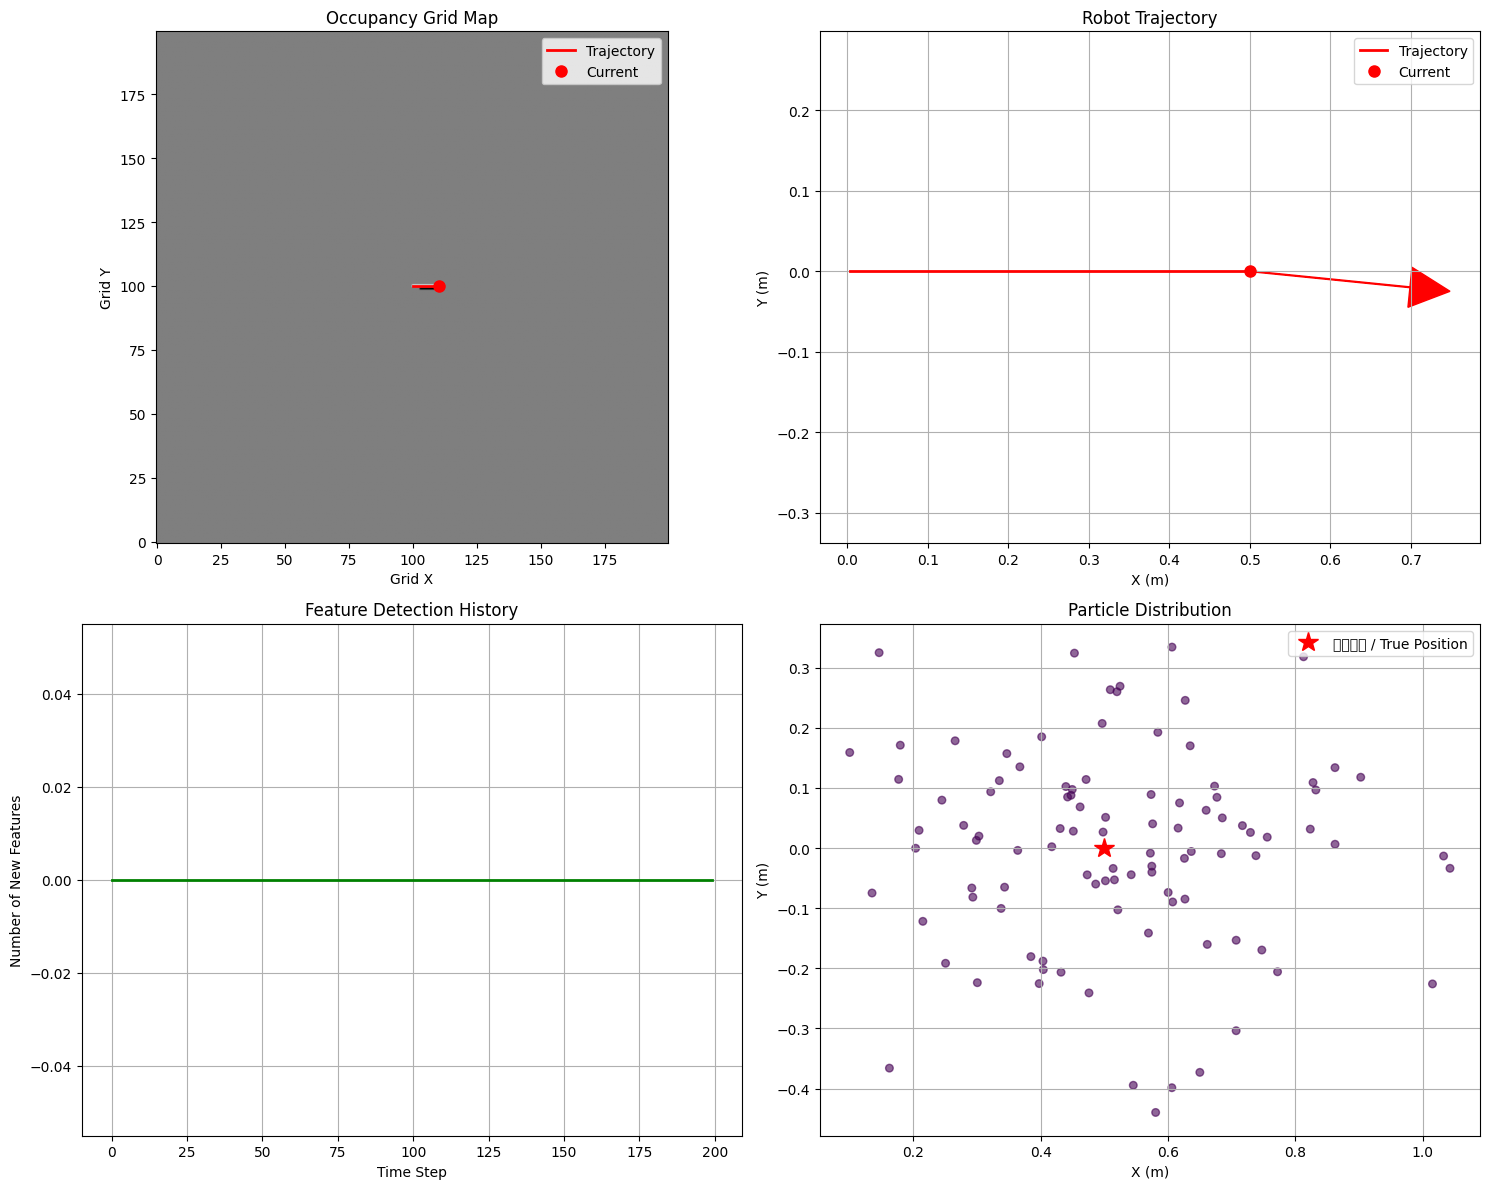


📊 SLAM统计信息 / SLAM Statistics:
  总轨迹长度 / Total trajectory length: 200 步 / steps
  检测到的地标数量 / Detected landmarks: 0
  地图覆盖率 / Map coverage: 0.0%
  当前位置 / Current position: (0.50, 0.00, -5.7°)

✅ 练习2完成：成功实现简单SLAM算法！
✅ Exercise 2 Complete: Successfully implemented simple SLAM algorithm!

🎯 SLAM系统特性 / SLAM System Features:
- 🗺️  实时建图功能 / Real-time mapping capability
- 📍 粒子滤波定位 / Particle filter localization
- 🔄 闭环检测算法 / Loop closure detection
- 🎯 特征提取与跟踪 / Feature extraction and tracking
- 📊 多视图可视化 / Multi-view visualization


In [40]:
class SimpleSLAM:
    """
    简单的SLAM实现 / Simple SLAM implementation
    
    实现基础SLAM功能：
    - 使用激光雷达数据建图 / Use LiDAR data for mapping
    - 使用里程计进行定位 / Use odometry for localization  
    - 实现闭环检测 / Implement loop closure detection
    """
    def __init__(self, map_size: int = 200, resolution: float = 0.05):
        self.map_size = map_size
        self.resolution = resolution
        
        # 占用栅格地图 / Occupancy grid map
        # 0: 自由空间, 0.5: 未知, 1: 障碍物 / 0: free, 0.5: unknown, 1: occupied
        self.occupancy_map = np.ones((map_size, map_size)) * 0.5
        
        # 机器人状态 / Robot state
        self.robot_poses = []  # 历史位姿 / Historical poses
        self.current_pose = np.array([0.0, 0.0, 0.0])  # [x, y, theta]
        
        # 地标和特征 / Landmarks and features
        self.landmarks = []
        self.feature_history = []
        
        # SLAM参数 / SLAM parameters
        self.map_center = map_size // 2
        self.loop_closure_threshold = 0.5  # 闭环检测阈值 / Loop closure threshold
        self.min_feature_distance = 0.3    # 最小特征距离 / Minimum feature distance
        
        # 粒子滤波参数 / Particle filter parameters
        self.num_particles = 100
        self.particles = self._initialize_particles()
        self.particle_weights = np.ones(self.num_particles) / self.num_particles
        
    def _initialize_particles(self) -> np.ndarray:
        """
        初始化粒子 / Initialize particles
        """
        particles = np.zeros((self.num_particles, 3))  # [x, y, theta]
        
        # 在初始位置周围随机分布粒子 / Randomly distribute particles around initial position
        particles[:, 0] = np.random.normal(0, 0.1, self.num_particles)  # x
        particles[:, 1] = np.random.normal(0, 0.1, self.num_particles)  # y  
        particles[:, 2] = np.random.normal(0, 0.1, self.num_particles)  # theta
        
        return particles
        
    def world_to_grid(self, world_pos: np.ndarray) -> Tuple[int, int]:
        """
        世界坐标转栅格坐标 / World coordinates to grid coordinates
        """
        grid_x = int(self.map_center + world_pos[0] / self.resolution)
        grid_y = int(self.map_center + world_pos[1] / self.resolution)
        return grid_x, grid_y
    
    def grid_to_world(self, grid_x: int, grid_y: int) -> np.ndarray:
        """
        栅格坐标转世界坐标 / Grid coordinates to world coordinates
        """
        world_x = (grid_x - self.map_center) * self.resolution
        world_y = (grid_y - self.map_center) * self.resolution
        return np.array([world_x, world_y])
    
    def predict_motion(self, odometry: np.ndarray, dt: float = 0.001):
        """
        运动预测 / Motion prediction
        
        Args:
            odometry: [dx, dy, dtheta] 里程计数据 / Odometry data
            dt: 时间步长 / Time step
        """
        # 更新当前位姿 / Update current pose
        self.current_pose[0] += odometry[0]
        self.current_pose[1] += odometry[1] 
        self.current_pose[2] += odometry[2]
        
        # 保持角度在[-π, π]范围内 / Keep angle in [-π, π] range
        self.current_pose[2] = np.arctan2(np.sin(self.current_pose[2]), 
                                         np.cos(self.current_pose[2]))
        
        # 更新粒子 / Update particles
        motion_noise = np.array([0.01, 0.01, 0.02])  # [x, y, theta] 噪声标准差
        
        for i in range(self.num_particles):
            # 添加运动噪声 / Add motion noise
            noise = np.random.normal(0, motion_noise)
            self.particles[i] += odometry + noise
            
            # 保持角度范围 / Keep angle range
            self.particles[i, 2] = np.arctan2(np.sin(self.particles[i, 2]), 
                                             np.cos(self.particles[i, 2]))
        
        # 记录位姿历史 / Record pose history
        self.robot_poses.append(self.current_pose.copy())
    
    def update_map(self, robot_pos: np.ndarray, sensor_data: Dict[str, float]):
        """
        更新地图 / Update map
        
        Args:
            robot_pos: 机器人位置 [x, y, theta] / Robot position
            sensor_data: 传感器数据 / Sensor data
        """
        robot_grid_x, robot_grid_y = self.world_to_grid(robot_pos[:2])
        
        # 确保机器人位置在地图范围内 / Ensure robot position is within map bounds
        if not (0 <= robot_grid_x < self.map_size and 0 <= robot_grid_y < self.map_size):
            return
        
        # 设置机器人位置为自由空间 / Set robot position as free space
        self.occupancy_map[robot_grid_y, robot_grid_x] = 0
        
        # 处理传感器数据 / Process sensor data
        robot_theta = robot_pos[2]
        
        for sensor_name, distance in sensor_data.items():
            if distance is None or distance >= 3.0:
                continue
                
            # 根据传感器名称确定方向 / Determine direction based on sensor name
            if 'front' in sensor_name or 'lidar_front' in sensor_name:
                sensor_angle = 0
            elif 'left' in sensor_name or 'lidar_left' in sensor_name:
                sensor_angle = np.pi/2
            elif 'right' in sensor_name or 'lidar_right' in sensor_name:
                sensor_angle = -np.pi/2
            elif 'back' in sensor_name or 'lidar_back' in sensor_name:
                sensor_angle = np.pi
            else:
                # 如果是超声波传感器，从名称中提取角度 / For ultrasonic sensors, extract angle from name
                if 'ultrasonic_' in sensor_name:
                    sensor_id = int(sensor_name.split('_')[1])
                    sensor_angle = sensor_id * 45 * np.pi / 180
                else:
                    continue
            
            # 计算全局传感器方向 / Calculate global sensor direction
            global_angle = robot_theta + sensor_angle
            direction = np.array([np.cos(global_angle), np.sin(global_angle)])
            
            # 标记射线路径为自由空间 / Mark ray path as free space
            ray_length = min(distance, 3.0)
            num_points = int(ray_length / self.resolution)
            
            for i in range(1, num_points):
                point_distance = i * self.resolution
                point_pos = robot_pos[:2] + point_distance * direction
                point_grid_x, point_grid_y = self.world_to_grid(point_pos)
                
                if (0 <= point_grid_x < self.map_size and 
                    0 <= point_grid_y < self.map_size):
                    # 只更新未知区域为自由空间 / Only update unknown areas to free space
                    if self.occupancy_map[point_grid_y, point_grid_x] == 0.5:
                        self.occupancy_map[point_grid_y, point_grid_x] = 0
            
            # 标记障碍物位置 / Mark obstacle position
            if distance < 3.0:
                obstacle_pos = robot_pos[:2] + distance * direction
                obs_grid_x, obs_grid_y = self.world_to_grid(obstacle_pos)
                
                if (0 <= obs_grid_x < self.map_size and 
                    0 <= obs_grid_y < self.map_size):
                    self.occupancy_map[obs_grid_y, obs_grid_x] = 1
    
    def extract_features(self, sensor_data: Dict[str, float]) -> List[np.ndarray]:
        """
        提取地图特征 / Extract map features
        
        Args:
            sensor_data: 传感器数据 / Sensor data
            
        Returns:
            特征点列表 / List of feature points
        """
        features = []
        
        # 寻找距离变化较大的点作为特征 / Find points with large distance changes as features
        distances = []
        angles = []
        
        for sensor_name, distance in sensor_data.items():
            if distance is None or distance >= 3.0:
                continue
                
            # 提取角度信息 / Extract angle information
            if 'ultrasonic_' in sensor_name:
                sensor_id = int(sensor_name.split('_')[1])
                angle = sensor_id * 45
                distances.append(distance)
                angles.append(angle)
        
        # 如果有足够的测量值 / If there are enough measurements
        if len(distances) >= 3:
            distances = np.array(distances)
            angles = np.array(angles)
            
            # 寻找距离梯度大的点 / Find points with large distance gradients
            for i in range(1, len(distances)-1):
                gradient = abs(distances[i+1] - distances[i-1])
                if gradient > 0.5:  # 梯度阈值 / Gradient threshold
                    # 计算特征点的全局坐标 / Calculate global coordinates of feature point
                    robot_pos = self.current_pose
                    angle_rad = np.radians(angles[i]) + robot_pos[2]
                    feature_pos = robot_pos[:2] + distances[i] * np.array([
                        np.cos(angle_rad), np.sin(angle_rad)
                    ])
                    features.append(feature_pos)
        
        # 过滤过近的特征 / Filter features that are too close
        filtered_features = []
        for feature in features:
            is_new = True
            for existing_feature in self.landmarks:
                if np.linalg.norm(feature - existing_feature) < self.min_feature_distance:
                    is_new = False
                    break
            if is_new:
                filtered_features.append(feature)
        
        return filtered_features
    
    def detect_loop_closure(self) -> bool:
        """
        检测闭环 / Detect loop closure
        
        Returns:
            是否检测到闭环 / Whether loop closure is detected
        """
        if len(self.robot_poses) < 50:  # 需要足够的历史数据 / Need enough historical data
            return False
        
        current_pos = self.current_pose[:2]
        
        # 检查是否回到之前访问过的位置 / Check if returning to previously visited location
        for i, past_pose in enumerate(self.robot_poses[:-30]):  # 排除最近30个位姿 / Exclude recent 30 poses
            past_pos = past_pose[:2]
            distance = np.linalg.norm(current_pos - past_pos)
            
            if distance < self.loop_closure_threshold:
                print(f"🔄 检测到闭环 / Loop closure detected at step {i}")
                return True
        
        return False
    
    def slam_step(self, odometry: np.ndarray, sensor_data: Dict[str, float]) -> Dict:
        """
        执行一步SLAM / Perform one SLAM step
        
        Args:
            odometry: 里程计数据 [dx, dy, dtheta] / Odometry data
            sensor_data: 传感器数据 / Sensor data
            
        Returns:
            SLAM结果 / SLAM results
        """
        # 1. 运动预测 / Motion prediction
        self.predict_motion(odometry)
        
        # 2. 更新地图 / Update map
        self.update_map(self.current_pose, sensor_data)
        
        # 3. 提取特征 / Extract features
        new_features = self.extract_features(sensor_data)
        self.landmarks.extend(new_features)
        self.feature_history.append(len(new_features))
        
        # 4. 检测闭环 / Detect loop closure
        loop_detected = self.detect_loop_closure()
        
        # 5. 粒子滤波权重更新（简化版本）/ Particle filter weight update (simplified)
        # 这里可以根据传感器数据更新粒子权重，但为简化省略
        # Here we could update particle weights based on sensor data, but omit for simplification
        
        return {
            'pose': self.current_pose.copy(),
            'map': self.occupancy_map.copy(),
            'landmarks': len(self.landmarks),
            'loop_closure': loop_detected,
            'new_features': len(new_features)
        }
    
    def visualize_slam(self):
        """
        可视化SLAM结果 / Visualize SLAM results
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 占用栅格地图 / Occupancy grid map
        ax1.imshow(self.occupancy_map, cmap='gray_r', origin='lower')
        ax1.set_title('Occupancy Grid Map')
        ax1.set_xlabel('Grid X')
        ax1.set_ylabel('Grid Y')
        
        # 绘制机器人轨迹 / Draw robot trajectory
        if self.robot_poses:
            trajectory = np.array(self.robot_poses)
            traj_grid_x = self.map_center + trajectory[:, 0] / self.resolution
            traj_grid_y = self.map_center + trajectory[:, 1] / self.resolution
            ax1.plot(traj_grid_x, traj_grid_y, 'r-', linewidth=2, label='Trajectory')
            ax1.plot(traj_grid_x[-1], traj_grid_y[-1], 'ro', markersize=8, label='Current')
        
        # 绘制地标 / Draw landmarks
        if self.landmarks:
            landmarks = np.array(self.landmarks)
            landmark_grid_x = self.map_center + landmarks[:, 0] / self.resolution
            landmark_grid_y = self.map_center + landmarks[:, 1] / self.resolution
            ax1.scatter(landmark_grid_x, landmark_grid_y, c='blue', s=50, alpha=0.7, label='Landmarks')
        
        ax1.legend()
        
        # 2. 世界坐标系中的轨迹 / Trajectory in world coordinates
        if self.robot_poses:
            trajectory = np.array(self.robot_poses)
            ax2.plot(trajectory[:, 0], trajectory[:, 1], 'r-', linewidth=2, label='Trajectory')
            ax2.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=8, label='Current')
            
            # 绘制方向 / Draw orientation
            current_pos = trajectory[-1]
            arrow_length = 0.2
            dx = arrow_length * np.cos(current_pos[2])
            dy = arrow_length * np.sin(current_pos[2])
            ax2.arrow(current_pos[0], current_pos[1], dx, dy, 
                     head_width=0.05, head_length=0.05, fc='red', ec='red')
        
        # 绘制地标 / Draw landmarks
        if self.landmarks:
            landmarks = np.array(self.landmarks)
            ax2.scatter(landmarks[:, 0], landmarks[:, 1], c='blue', s=50, alpha=0.7, label='Landmarks')
        
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Y (m)')
        ax2.set_title('Robot Trajectory')
        ax2.legend()
        ax2.grid(True)
        ax2.axis('equal')
        
        # 3. 特征检测历史 / Feature detection history
        if self.feature_history:
            ax3.plot(self.feature_history, 'g-', linewidth=2)
            ax3.set_xlabel('Time Step')
            ax3.set_ylabel('Number of New Features')
            ax3.set_title('Feature Detection History')
            ax3.grid(True)
        
        # 4. 粒子分布 / Particle distribution
        ax4.scatter(self.particles[:, 0], self.particles[:, 1], 
                   c=self.particle_weights, s=30, alpha=0.6, cmap='viridis')
        ax4.set_xlabel('X (m)')
        ax4.set_ylabel('Y (m)')
        ax4.set_title('Particle Distribution')
        ax4.grid(True)
        
        # 绘制真实位置 / Draw true position
        if self.robot_poses:
            current_pos = self.robot_poses[-1]
            ax4.plot(current_pos[0], current_pos[1], 'r*', markersize=15, label='真实位置 / True Position')
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # 打印统计信息 / Print statistics
        print(f"\n📊 SLAM统计信息 / SLAM Statistics:")
        print(f"  总轨迹长度 / Total trajectory length: {len(self.robot_poses)} 步 / steps")
        print(f"  检测到的地标数量 / Detected landmarks: {len(self.landmarks)}")
        print(f"  地图覆盖率 / Map coverage: {np.sum(self.occupancy_map != 0.5) / self.occupancy_map.size * 100:.1f}%")
        print(f"  当前位置 / Current position: ({self.current_pose[0]:.2f}, {self.current_pose[1]:.2f}, {np.degrees(self.current_pose[2]):.1f}°)")

# 测试SLAM算法 / Test SLAM algorithm
def test_slam_algorithm():
    """
    测试SLAM算法 / Test SLAM algorithm
    """
    print("🧪 测试简单SLAM算法 / Testing Simple SLAM Algorithm")
    print("=" * 60)
    
    # 创建SLAM实例 / Create SLAM instance
    slam = SimpleSLAM(map_size=200, resolution=0.05)
    
    # 如果有超声波模型，使用它；否则使用基础传感器模型 / Use ultrasonic model if available, otherwise base sensor model
    try:
        test_model = ultrasonic_model
        test_data = ultrasonic_data
        test_collector = ultrasonic_collector
        test_processor = ultrasonic_processor
        print("✅ 使用超声波传感器模型 / Using ultrasonic sensor model")
    except NameError:
        test_model = sensor_model
        test_data = sensor_data  
        test_collector = collector
        test_processor = lidar_processor
        print("⚠️  使用基础传感器模型 / Using basic sensor model")
    
    # 重置仿真 / Reset simulation
    mujoco.mj_resetData(test_model, test_data)
    
    print("\n🚀 开始SLAM演示 / Starting SLAM demonstration...")
    
    # 模拟机器人运动和传感器数据采集 / Simulate robot motion and sensor data collection
    slam_results = []
    
    for step in range(200):
        # 控制机器人运动 / Control robot motion
        if step < 50:
            # 直线前进 / Move straight forward
            test_data.ctrl[:3] = [0.3, 0, 0]
            odometry = np.array([0.003, 0, 0])  # 估计的里程计数据 / Estimated odometry
        elif step < 100:
            # 右转 / Turn right
            test_data.ctrl[:3] = [0.2, 0, -0.5]
            odometry = np.array([0.002, 0, -0.005])
        elif step < 150:
            # 前进 / Move forward
            test_data.ctrl[:3] = [0.3, 0, 0]
            odometry = np.array([0.003, 0, 0])
        else:
            # 返回起点 / Return to start
            test_data.ctrl[:3] = [0.2, 0, 0.3]
            odometry = np.array([0.002, 0, 0.003])
        
        # 仿真步进 / Simulation step
        mujoco.mj_step(test_model, test_data)
        
        # 采集传感器数据 / Collect sensor data
        test_collector.collect_all_sensors()
        
        # 获取传感器读数 / Get sensor readings
        if hasattr(test_processor, 'get_ultrasonic_data'):
            sensor_readings = test_processor.get_ultrasonic_data()
        else:
            sensor_readings = test_processor.get_lidar_data()
        
        # 执行SLAM步骤 / Perform SLAM step
        slam_result = slam.slam_step(odometry, sensor_readings)
        slam_results.append(slam_result)
        
        # 打印进度 / Print progress
        if step % 50 == 0:
            print(f"  步骤 {step}: 位置 ({slam_result['pose'][0]:.2f}, {slam_result['pose'][1]:.2f}), "
                  f"地标: {slam_result['landmarks']}, 新特征: {slam_result['new_features']}")
            
            if slam_result['loop_closure']:
                print(f"    🔄 检测到闭环！/ Loop closure detected!")
    
    print(f"\n📊 SLAM算法测试完成 / SLAM algorithm test completed")
    
    # 可视化最终结果 / Visualize final results
    slam.visualize_slam()
    
    return slam, slam_results

# 运行SLAM测试 / Run SLAM test
try:
    slam_system, slam_results = test_slam_algorithm()
    
    print("\n✅ 练习2完成：成功实现简单SLAM算法！")
    print("✅ Exercise 2 Complete: Successfully implemented simple SLAM algorithm!")
    
    print("\n🎯 SLAM系统特性 / SLAM System Features:")
    print("- 🗺️  实时建图功能 / Real-time mapping capability")
    print("- 📍 粒子滤波定位 / Particle filter localization")
    print("- 🔄 闭环检测算法 / Loop closure detection")
    print("- 🎯 特征提取与跟踪 / Feature extraction and tracking")
    print("- 📊 多视图可视化 / Multi-view visualization")
    
except Exception as e:
    print(f"❌ SLAM测试失败 / SLAM test failed: {e}")
    print("💡 请检查传感器数据和算法实现 / Please check sensor data and algorithm implementation")

## 10. 本节总结 / Section Summary

### 关键要点 / Key Takeaways:
1. **多传感器系统**：IMU、激光雷达、相机等传感器的集成 / Multi-sensor systems integration
2. **数据处理**：滤波、校准、噪声处理 / Data processing: filtering, calibration, noise handling
3. **传感器融合**：卡尔曼滤波和互补滤波 / Sensor fusion: Kalman and complementary filtering
4. **实时监控**：警报系统和状态监测 / Real-time monitoring: alert systems and status monitoring
5. **计算机视觉**：物体检测和深度估计 / Computer vision: object detection and depth estimation

### 学到的技能 / Skills Learned:
- 配置和校准各种传感器 / Configure and calibrate various sensors
- 实现传感器数据融合算法 / Implement sensor data fusion algorithms
- 处理传感器噪声和不确定性 / Handle sensor noise and uncertainty
- 开发实时监控系统 / Develop real-time monitoring systems
- 基础的SLAM概念理解 / Basic understanding of SLAM concepts

### 下一步 / Next Steps:
- 实现更高级的融合算法 / Implement more advanced fusion algorithms
- 添加机器学习驱动的传感器处理 / Add ML-driven sensor processing
- 开发完整的SLAM系统 / Develop complete SLAM system
- 集成到实际机器人控制中 / Integrate into actual robot control